In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

In [3]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, Image

In [4]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# Cas12a and Cas9 Modeling

This notebook contains the code used for modeling the behavior of Cas12a and Cas9 variants, and is specific to that purpose. Advanced users may find it useful to adapt this code for their modeling needs.

In [5]:
import re
import yaml
from collections import defaultdict
from nucleaseq.OligosContainer import OligosContainer
from nucleaseq import seqtools, processing, plotting, resultsio

In [6]:
targets = yaml.load(open('/shared/targets.yml'))

In [7]:
real_cas9_var = 'HF1'
prots = ['Cas12a', 'HF1']
target_names = ['D', 'E']
first_time_point = 12
last_time_point = 60000

In [8]:
cleavage_rate_fpaths_given_target_given_prot = {
    'Cas12a': {
        'D': [
            '/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/experiments/20181022-nucseq/C12a_cleavage_rate_and_y0.txt',
            '/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/experiments/20190214-nucseq/D_C12_cleavage_rate_and_y0.txt',
        ],
        'E': [
            '/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/experiments/20180829-nucseq/ECas12a_cleavage_rate_and_y0.txt',
        ]
    },
    'HF1': {
        'D': [
            '/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/experiments/20181022-nucseq/HF_cleavage_rate_and_y0.txt',
        ],
        'E': [
            '/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/experiments/20180803/HF1E_cleavage_rate_and_y0.txt',
        ]
    }
}

# Load data

In [9]:
first_time_point_cleavage_rate = np.log(2)/first_time_point
last_time_point_cleavage_rate = np.log(2)/last_time_point

In [10]:
cleavage_rate_recs_given_run = {}
cleavage_rates_and_errs_given_run = {}
perfect_targets = {}
perfect_target_cleavage_rate_given_run = defaultdict(list)
for prot in prots:
    for tname in target_names:
        for i, fpath in enumerate(cleavage_rate_fpaths_given_target_given_prot[prot][tname]):
            run = (prot, tname, i+1)
            perfect_targets[run] = targets[tname]

            res = resultsio.read_cleavage_rates_file(fpath)
            cleavage_rate_recs_given_run[run] = res
            cleavage_rates_and_errs = {}
            for rec in res:
                if rec.y0 < 20:
                    continue
                if first_time_point_cleavage_rate < rec.cleavage_rate:
                    cleavage_rate = np.log10(first_time_point_cleavage_rate)
                    log10_err = 2
                elif last_time_point_cleavage_rate > rec.cleavage_rate:
                    cleavage_rate = np.log10(last_time_point_cleavage_rate)
                    log10_err = 2
                else:
                    cleavage_rate = np.log10(rec.cleavage_rate)
                    log10_err = rec.log10_cleavage_rate_err
                cleavage_rates_and_errs[rec.target] = (cleavage_rate, log10_err)
                if rec.target == perfect_targets[run]:
                    perfect_target_cleavage_rate_given_run[run].append(cleavage_rate)
            cleavage_rates_and_errs_given_run[run] = cleavage_rates_and_errs
perfect_target_cleavage_rate_given_run = {tname: np.average(crs) for tname, crs 
                                           in perfect_target_cleavage_rate_given_run.items()}

In [11]:
perfect_targets

{('Cas12a', 'D', 1): 'TTTAGTGATAAGTGGAATGCCATGTGG',
 ('Cas12a', 'D', 2): 'TTTAGTGATAAGTGGAATGCCATGTGG',
 ('Cas12a', 'E', 1): 'TTTAGACGCATAAAGATGAGACGCTGG',
 ('HF1', 'D', 1): 'TTTAGTGATAAGTGGAATGCCATGTGG',
 ('HF1', 'E', 1): 'TTTAGACGCATAAAGATGAGACGCTGG'}

In [12]:
for k, v in cleavage_rates_and_errs_given_run.items():
    print k, len(v)

('HF1', 'E', 1) 9955
('Cas12a', 'D', 2) 7936
('Cas12a', 'E', 1) 9956
('HF1', 'D', 1) 8584
('Cas12a', 'D', 1) 8585


In [13]:
perfect_target_cleavage_rate_given_run

{('Cas12a', 'D', 1): -1.8446562378830815,
 ('Cas12a', 'D', 2): -1.6893373553701783,
 ('Cas12a', 'E', 1): -2.4117928332633092,
 ('HF1', 'D', 1): -1.4486816047335644,
 ('HF1', 'E', 1): -1.4328731947899589}

### Replicate Data

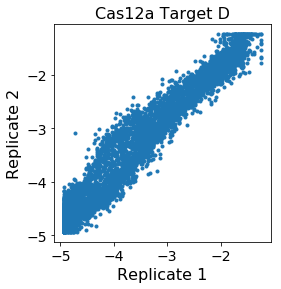

In [14]:
for key, cleavage_rates_and_errs in sorted(cleavage_rates_and_errs_given_run.items()):
    prot, tname, rep = key
    key2 = (prot, tname, 2)
    if rep == 2 or key2 not in cleavage_rates_and_errs_given_run:
        continue
    fig, ax = plt.subplots()
    x, y = [], []
    for seq, (cleavage_rate, cleavage_rate_err) in cleavage_rates_and_errs.items():
        if seq in cleavage_rates_and_errs_given_run[key2]:
            x.append(cleavage_rate)
            y.append(cleavage_rates_and_errs_given_run[key2][seq][0])
    ax.plot(x, y, '.')
    ax.set_aspect(1)
    ax.set_xlabel('Replicate 1')
    ax.set_ylabel('Replicate 2')
    ax.set_title('{} Target {}'.format(prot.capitalize(), tname.upper()))

In [15]:
norm_cleavage_rates_and_errs_given_run = cleavage_rates_and_errs_given_run

# Sequence alignment and edits lists

The models rely on the aligned version of the sequence to determine the edits present. So first, let us find such alignments.

In [16]:
from scipy.special import expit
import random
from collections import Counter

In [17]:
from Bio.pairwise2 import align

In [18]:
def aligned_seqs(s1, s2):
    a = align.globalms(s1, s2, 2, -.2, -.2, -.1)
    return a[0][0], a[0][1]

In [19]:
sp1 = 'TCTACACTCTTTCCCTACACGACGCTCTTCCGATCT'
sp2 = 'AGATCGGAAGAGCACACGTCTGAACTCCAGTCAC'

In [20]:
def aligned_seqs_separate_pam(prot, ref_seq, obs_seq):
    # Processing of sequences to find aligned seqs
    # Step 1: align the given seqs
    # Step 2: break off the pam, filling pam ends with sp1 or sp2 as appropriate
    # Step 3: end the alignment at the end of the ref seq, filling pam-distal end with sp1 or sp2 as appropriate
    
    # Step 1
    ref_aligned, obs_aligned = aligned_seqs(ref_seq, obs_seq)
    if prot == 'Cas12a':
        # Step 2
        cut_idx = min(ref_aligned.index('A') + 1, ref_aligned.index('C') + 1)
        pam = sp1 + obs_aligned[:cut_idx].replace('-', '')
        pam = pam[-4:]
        ref_aligned = ref_aligned[cut_idx:]
        obs_aligned = obs_aligned[cut_idx:]
        # Step 3
        last_idx = [i for i, c in enumerate(ref_aligned) if c != '-'][-1]
        ref_aligned = ref_aligned[:last_idx + 1]
        obs_aligned = obs_aligned.rstrip('-') + sp2
        obs_aligned = obs_aligned[:last_idx + 1]
    else:
        assert prot == 'HF1', prot
        # Step 2
        cut_idx = ref_aligned.rfind('T')
        pam = obs_aligned[cut_idx:].replace('-', '') + sp2
        pam = pam[:3]
        ref_aligned = ref_aligned[:cut_idx]
        obs_aligned = obs_aligned[:cut_idx]
        # Step 3
        first_idx = [i for i, c in enumerate(ref_aligned) if c != '-'][0]
        ref_aligned = ref_aligned[first_idx:]
        obs_aligned = sp1 + obs_aligned.lstrip('-')
        obs_aligned = obs_aligned[-len(ref_aligned):]
    return pam, ref_aligned, obs_aligned

In [21]:
aligned_norm_cleavage_rates_and_errs_given_run = {}
for run, cleavage_rates_and_errs in norm_cleavage_rates_and_errs_given_run.items():
    aligned_norm_cleavage_rates_and_errs_given_run[run] = {}
    perfect_target = perfect_targets[run]
    prot, tname, rep = run
    for seq, cleavage_rate_tup in cleavage_rates_and_errs.items():
        pam, ref_aligned, obs_aligned = aligned_seqs_separate_pam(prot, perfect_target, seq)
        aligned_norm_cleavage_rates_and_errs_given_run[run][(pam, ref_aligned, obs_aligned)] = cleavage_rate_tup

In [22]:
bases = 'ACGT'
bases_and_deletion = bases + '-'

In [23]:
def build_coord_ref_obs(prot, ref_aligned, obs_aligned):
    # cro = coord, ref, obs
    if prot == 'Cas12a':
        base_tups = zip(ref_aligned, obs_aligned)
    else:
        assert prot == 'HF1', prot
        base_tups = zip(ref_aligned, obs_aligned)[::-1]

    sub_cro, del_cro, ins_cro = [], [], []
    i = 0
    for rc, oc in base_tups:
        if rc != oc:
            #cro = (i, rc, oc)
            cro = (i, bases_and_deletion.index(rc), bases_and_deletion.index(oc))
            if rc == '-':
                ins_cro.append(cro)
            elif oc == '-':
                del_cro.append(cro)
            else:
                sub_cro.append(cro)
        if rc != '-':
            i += 1
    return sub_cro, del_cro, ins_cro

In [24]:
def build_force_sub_coord_ref_obs(prot, ref_aligned, obs_aligned):
    # cro = coord, ref, obs
    ref_aligned = ref_aligned.replace('-', '')
    obs_aligned = obs_aligned.replace('-', '')
    if prot == 'Cas12a':
        obs_aligned = obs_aligned[:len(ref_aligned)]
        base_tups = zip(ref_aligned, obs_aligned)
    else:
        assert prot == 'HF1', prot
        obs_aligned = obs_aligned[-len(ref_aligned):]
        base_tups = zip(ref_aligned, obs_aligned)[::-1]

    sub_cro, del_cro, ins_cro = [], [], []
    i = 0
    for rc, oc in base_tups:
        if rc != oc:
            #cro = (i, rc, oc)
            cro = (i, bases_and_deletion.index(rc), bases_and_deletion.index(oc))
            if rc == '-':
                ins_cro.append(cro)
            elif oc == '-':
                del_cro.append(cro)
            else:
                sub_cro.append(cro)
        if rc != '-':
            i += 1
    return sub_cro, del_cro, ins_cro

In [25]:
data = []
force_sub_data = []
for run, cleavage_rates_and_errs in norm_cleavage_rates_and_errs_given_run.items():
    perfect_target = perfect_targets[run]
    prot, tname, rep = run
    if prot == 'Cas12a':
        ref_pam = 'TTTA'
    else:
        assert prot == 'HF1', prot
        ref_pam = 'TGG'
    for seq, cleavage_rate_tup in cleavage_rates_and_errs.items():
        pam, ref_aligned, obs_aligned = aligned_seqs_separate_pam(prot, perfect_target, seq)
        pam_cro = [(i, bases.index(rc), bases.index(oc)) for i, (rc, oc) in enumerate(zip(ref_pam, pam)) if rc != oc]
        sub_cro, del_cro, ins_cro = build_coord_ref_obs(prot, ref_aligned, obs_aligned)
        cleavage_rate, err = cleavage_rate_tup
        cleavage_rate_tup = (cleavage_rate, err)
        data.append((run, seq, pam_cro, sub_cro, del_cro, ins_cro, cleavage_rate_tup))
        sub_cro, del_cro, ins_cro = build_force_sub_coord_ref_obs(prot, ref_aligned, obs_aligned)
        force_sub_data.append((run, seq, pam_cro, sub_cro, del_cro, ins_cro, cleavage_rate_tup))

In [26]:
cas12a_data = [tup for tup in data if tup[0][0] == 'Cas12a']
cas9_data = [tup for tup in data if tup[0][0] == 'HF1']

In [27]:
cas12a_force_sub_data = [tup for tup in force_sub_data if tup[0][0] == 'Cas12a']
cas9_force_sub_data = [tup for tup in force_sub_data if tup[0][0] == 'HF1']

In [28]:
len(data), len(cas12a_data), len(cas9_data)

(45016, 26477, 18539)

In [29]:
len(force_sub_data), len(cas12a_force_sub_data), len(cas9_force_sub_data)

(45016, 26477, 18539)

In [30]:
sum(len(sub_cro) for run, seq, pam_cro, sub_cro, del_cro, ins_cro, cleavage_rate_tup in cas12a_force_sub_data)

171000

In [31]:
def num_edits(tup):
    return sum(map(len, tup[2:6]))

In [32]:
cas12a_single_edit_data = [tup for tup in cas12a_data if sum(map(len, tup[2:6])) <= 1]
cas12a_double_edit_data = [tup for tup in cas12a_data if sum(map(len, tup[2:6])) <= 2]

In [33]:
len(cas12a_single_edit_data), len(cas12a_double_edit_data)

(2335, 22172)

In [34]:
cas9_single_edit_data = [tup for tup in cas9_data if sum(map(len, tup[2:6])) <= 1]
cas9_double_edit_data = [tup for tup in cas9_data if sum(map(len, tup[2:6])) <= 2]

In [35]:
len(cas9_single_edit_data), len(cas9_double_edit_data)

(1503, 15313)

In [36]:
tup = random.choice(cas12a_single_edit_data)
prot, tname, rep = tup[0]
seq = tup[1]
perfect_target = perfect_targets[tup[0]]
print '\n'.join(aligned_seqs_separate_pam(prot, perfect_target, seq))
tup

TTTA
GTGATAAGTGGAATG-CCATGTGG
GTGATAAGTGGAATGACCATGTGG


(('Cas12a', 'D', 1),
 'TTTAGTGATAAGTGGAATGACCATGTGG',
 [],
 [],
 [],
 [(15, 4, 0)],
 (-3.2277877732947839, 0.0326261925311))

In [37]:
Counter(tup[0] for tup in cas12a_single_edit_data)

Counter({('Cas12a', 'D', 1): 747,
         ('Cas12a', 'D', 2): 684,
         ('Cas12a', 'E', 1): 904})

In [38]:
Counter(tup[0] for tup in cas12a_double_edit_data)

Counter({('Cas12a', 'D', 1): 7409,
         ('Cas12a', 'D', 2): 6880,
         ('Cas12a', 'E', 1): 7883})

In [39]:
tup = random.choice(cas9_single_edit_data)
prot, tname, rep = tup[0]
seq = tup[1]
perfect_target = perfect_targets[tup[0]]
print '\n'.join(aligned_seqs_separate_pam(prot, perfect_target, seq))
tup

TGG
T-TTAGACGCATAAAGATGAGACGC
TATTAGACGCATAAAGATGAGACGC


(('HF1', 'E', 1),
 'TATTAGACGCATAAAGATGAGACGCTGG',
 [],
 [],
 [],
 [(23, 4, 0)],
 (-1.2383557850024864, 2))

In [40]:
Counter(tup[0] for tup in cas9_single_edit_data)

Counter({('HF1', 'D', 1): 655, ('HF1', 'E', 1): 848})

In [41]:
Counter(tup[0] for tup in cas9_double_edit_data)

Counter({('HF1', 'D', 1): 7348, ('HF1', 'E', 1): 7965})

## Single Effects Model
The pre-hinge single effects model is given by:

\begin{align}
     CleavageRate = 
        & PerfectCleavageRate \\
        &+ \sum_{i \in PAM} PAMPen(i, s_i) \\
        &+ \sum_{i \in Deletions} DelPen(i) \\
        &+ \sum_{i \in Insertions} InsPen(i) * InsWeight(s_i) \\
        &+ \sum_{i \in Target} SubPen(i) * SubTrans(r_i, s_i) \\
\end{align}


In the function names, $Pen$ indicates a penalty, $Trans$ indicates a transition weight, and $Weight$ indicates a reference-free weight. $Sub$, $Del$, and $Ins$ refer to substitutions, deletions, and insertions. And we only allow substitutions in the PAM, so the $PAM$ function name indicates PAM-specific substitution penalties and transition weights. The $Pen$ functions depend only on position, the $Trans$ functions depend only on reference and sequenced bases $r$ and $s$, and the $InsWeight$ function depends only on the observed sequence base $s$.

## Hinge 

I am first going to try a "bandpass hinge function". Let $f$ be the fastest and $s$ the slowest cleavage rates within our detection limits. Then we define the bandpass hinge function to be

$$
    BandpassHinge(x) = 
        \begin{cases}
        x & s < x < f \\
        f & x \geq f \\
        s & x \leq s
        \end{cases}
$$

In [42]:
log10_ub = np.log10(first_time_point_cleavage_rate)
log10_lb = np.log10(last_time_point_cleavage_rate)
data_span = log10_ub - log10_lb

def bandpass_hinge(x):
    return max(log10_lb, min(x, log10_ub))

### Transition Matrix with Total Average 1: Hadamard Matrices

What we want is for all the off-diagonal elements to average 1. This is critically different from enforcing a row average of 1, as we want to allow that some reference bases are easier/harder to replace than others overall. 

The problem of balanced parameterization is more difficult in this case. There are now 12 values of interest, $a_1, \dots, a_{12}$, which have 11 degrees of freedom $x_1, \dots, x_{11}$. The simplest parameterization would be

$$
    a_1 = x_1, \ \dots , \ a_{11} = x_{11}, \ a_{12} = 12 - \sum_{i=1}^{11} x_i
$$

Which is very unbalanced. $a_{12}$ is sensitive to all changes to $x$, while all other $a_i$ depend on only one $x_i$. Because we are working with 12 parameters, we can instead use a Hadamard matrix $H_{12}$ to reparameterize:

$$
H_{12}\, a =
\begin{bmatrix}
 1 &  1 &  1 &  1 &  1 &  1 &  1 &  1 &  1 &  1 &  1 &  1 \\
 1 & -1 &  1 & -1 &  1 &  1 &  1 & -1 & -1 & -1 &  1 & -1 \\
 1 & -1 & -1 &  1 & -1 &  1 &  1 &  1 & -1 & -1 & -1 &  1 \\
 1 &  1 & -1 & -1 &  1 & -1 &  1 &  1 &  1 & -1 & -1 & -1 \\
 1 & -1 &  1 & -1 & -1 &  1 & -1 &  1 &  1 &  1 & -1 & -1 \\
 1 & -1 & -1 &  1 & -1 & -1 &  1 & -1 &  1 &  1 &  1 & -1 \\
 1 & -1 & -1 & -1 &  1 & -1 & -1 &  1 & -1 &  1 &  1 &  1 \\
 1 &  1 & -1 & -1 & -1 &  1 & -1 & -1 &  1 & -1 &  1 &  1 \\
 1 &  1 &  1 & -1 & -1 & -1 &  1 & -1 & -1 &  1 & -1 &  1 \\
 1 &  1 &  1 &  1 & -1 & -1 & -1 &  1 & -1 & -1 &  1 & -1 \\
 1 & -1 &  1 &  1 &  1 & -1 & -1 & -1 &  1 & -1 & -1 &  1 \\
 1 &  1 & -1 &  1 &  1 &  1 & -1 & -1 & -1 &  1 & -1 & -1 \\
\end{bmatrix}
a
=
\begin{bmatrix}
12 \\ x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5 \\ x_6 \\ x_7 \\ x_8 \\ x_9 \\ x_{10} \\ x_{11}
\end{bmatrix}
$$

A convenient property of Hadamard matrices is that
$$
    H_n^{-1} = \frac{1}{n} H_n^T.
$$
Hence, we can easily convert parameters $x$ to transition matrix values $a$ via the following equation:

$$
    a = \frac{1}{12}\, H_{12}^T\, \begin{bmatrix} 12 \\ \hline x \end{bmatrix}
$$

We will pull a similar trick with the InsWeights. Thankfully, we have 4 parameters, so again a Hadamard matrix exists. We will use
$$
H_4 \, a = 
\begin{bmatrix}
 1 &  1 &  1 &  1 \\
 1 & -1 &  1 & -1 \\
 1 & -1 & -1 &  1 \\
 1 &  1 & -1 & -1 \\
\end{bmatrix}
a
=
\begin{bmatrix}
4 \\ x_1 \\ x_2 \\ x_3
\end{bmatrix}
$$

and 
$$
a = \frac{1}{4} \, H_4^T \, \begin{bmatrix} 4 \\ \hline x \end{bmatrix}
$$

In [43]:
def flip_diagonal(M, diag):
    for i in range(M.shape[0]):
        r = i
        c = i + diag
        if 0 < r < M.shape[0] and 0 < c < M.shape[1]:
            M[r, c] *= -1
    return M

def build_H12():
    H12 = np.ones((12, 12))
    for diag in [0, -1, 2, -3, -4, -5, 6, 7, 8, -9, 10]:
        H12 = flip_diagonal(H12, diag)
    return H12

def build_H4():
    H4 = np.ones((4, 4))
    for diag in [0, -1, 2]:
        H4 = flip_diagonal(H4, diag)
    return H4

H12 = build_H12()
H12_T = H12.T

H4 = build_H4()
H4_T = H4.T

def unwrap_trans_mat(M):
    a = []
    for i in range(4):
        for j in range(4):
            if i != j:
                a.append(M[i, j])
    return np.array(a)

def wrap_trans_mat(a):
    M = np.zeros((4, 4))
    for i in range(4):
        for j in range(4):
            if i != j:
                idx = 3 * i + j
                if j > i:
                    idx -= 1
                M[i, j] = a[idx]
    return M

def balanced_trans_mat_full_avg(x):
    a = 1.0/12.0 * np.dot(H12_T, np.r_[[12], x])
    return wrap_trans_mat(a)

def full_avg_x_given_trans_mat(M):
    a = unwrap_trans_mat(M)
    ext_x = list(np.dot(H12, a))
    assert np.isclose(ext_x[0], 12), ext_x
    return ext_x[1:]

def balanced_ins_w(x):
    return 0.25 * np.dot(H4_T, np.r_[[4], x])

def x_given_ins_w(a):
    ext_x = list(np.dot(H4, a))
    assert np.isclose(ext_x[0], 4), ext_x
    return ext_x[1:]

In [44]:
bound_mult = 10.0
inv_bound_mult = 1.0/bound_mult

def bound_given_params(x):
    return [bound_mult * np.tanh(xx) for xx in x]

def params_given_bound(x):
    return [np.arctanh(inv_bound_mult * xx) for xx in x]

def initialize_pen(cro_idx, seqlen, single_edit_data):
    pen_lol = [[] for _ in range(seqlen)]
    for tup in single_edit_data:
        run = tup[0]
        cro = tup[cro_idx]
        if cro:
            assert len(cro) == 1, tup
            assert num_edits(tup) == 1, tup
            i, ri, oi = cro[0]
            cleavage_rate_tup = tup[-1]
            try:
                pen_lol[i].append(cleavage_rate_tup[0] - perfect_target_cleavage_rate_given_run[run])
            except IndexError:
                pass
    pen = [np.average(cleavage_rates_i) for cleavage_rates_i in pen_lol]
    
    # Remove nans with linear interpolation
    if np.isnan(pen[0]):
        pen[0] = -1
    if np.isnan(pen[-1]):
        pen[-1] = 0
    for i in range(len(pen)):
        if np.isnan(pen[i]):
            j = i+1
            while np.isnan(pen[j]):
                j += 1
            for idx in range(i, j):
                pen[idx] = pen[j] + (pen[i-1] - pen[j])/(i-1 - j) * (idx - j)
                
    # Bound within [-data_span, 0.9*data_span]
    pen = [max(-data_span, min(data_span, pp)) for pp in pen]
    pen_params = params_given_bound(pen)
    cov = [len(cleavage_rates_i) for cleavage_rates_i in pen_lol]
    return pen_params, pen, cov, pen_lol

def initialize_pen_and_trans(cro_idx, seqlen, single_edit_data):
    pen_params, pen, pen_cov, pen_lol = initialize_pen(cro_idx, seqlen, single_edit_data)
    valid_idxs = [i for i, p in enumerate(pen) if abs(p) > 0.2 * data_span]
    trans_lolol = [[[], [], [], []] for _ in range(4)]
    for tup in single_edit_data:
        cro = tup[cro_idx]
        if cro:
            assert len(cro) == 1, tup
            assert num_edits(tup) == 1, tup
            i, ri, oi = cro[0]
            if i in valid_idxs:
                cleavage_rate_tup = tup[-1]
                trans_lolol[ri][oi].append(
                    (cleavage_rate_tup[0] - perfect_target_cleavage_rate_given_run[run])/pen[i]
                )
    M = np.array([[np.average(cleavage_rates_ij) for cleavage_rates_ij in row] for row in trans_lolol])
    M /= (np.nansum(M) / 12)
    trans_mat_params = full_avg_x_given_trans_mat(M)
    cov = np.array([[len(cleavage_rates_ij) for cleavage_rates_ij in row] for row in trans_lolol])
    return pen_params, pen, pen_cov, pen_lol, trans_mat_params, M, cov, trans_lolol

def initialize_pen_and_weights(cro_idx, seqlen, single_edit_data):
    pen_params, pen, pen_cov, pen_lol = initialize_pen(cro_idx, seqlen, single_edit_data)
    valid_idxs = [i for i, p in enumerate(pen) if abs(p) > 0.2 * data_span]
    ins_lol = [[] for _ in range(4)]
    for tup in single_edit_data:
        cro = tup[cro_idx]
        if cro:
            assert len(cro) == 1, tup
            assert num_edits(tup) == 1, tup
            i, ri, oi = cro[0]
            assert ri == 4 and oi < 4, cro
            if i in valid_idxs:
                cleavage_rate_tup = tup[-1]
                ins_lol[oi].append(
                    (cleavage_rate_tup[0] - perfect_target_cleavage_rate_given_run[run])/pen[i]
                )
    ins_weights = np.array([np.average(cleavage_rates_i) for cleavage_rates_i in ins_lol])
    ins_weights /= np.average(ins_weights)
    cov = np.array([len(cleavage_rates_i) for cleavage_rates_i in ins_lol])
    ins_params = x_given_ins_w(ins_weights)
    return pen_params, pen, pen_cov, pen_lol, ins_params, ins_weights, cov, ins_lol

def initialize_PWM(cro_idx, seqlen, single_edit_data):
    pwm_lolol = [[[] for _ in range(seqlen)] for _ in range(4)]
    for tup in single_edit_data:
        cro = tup[cro_idx]
        if cro:
            assert len(cro) == 1, tup
            assert num_edits(tup) == 1, tup
            i, ri, oi = cro[0]
            cleavage_rate_tup = tup[-1]
            pwm_lolol[oi][i].append(cleavage_rate_tup[0] - perfect_target_cleavage_rate_given_run[run])
    PWM = np.array([[np.average(cleavage_rates_ij) for cleavage_rates_ij in row] for row in pwm_lolol])
    PWM[np.isnan(PWM)] = 0
    cov = np.array([[len(cleavage_rates_ij) for cleavage_rates_ij in row] for row in pwm_lolol])
    pwm_params = PWM.flatten()
    return list(pwm_params), PWM, cov

def initialize_nopen_subtrans(cro_idx, seqlen, single_edit_data):
    trans_lolol = [[[], [], [], []] for _ in range(4)]
    for tup in single_edit_data:
        cro = tup[cro_idx]
        if cro:
            assert len(cro) == 1, tup
            assert num_edits(tup) == 1, tup
            i, ri, oi = cro[0]
            cleavage_rate_tup = tup[-1]
            trans_lolol[ri][oi].append((cleavage_rate_tup[0] - perfect_target_cleavage_rate_given_run[run]))
    M = np.array([[np.average(cleavage_rates_ij) for cleavage_rates_ij in row] for row in trans_lolol])
    trans_mat_params = list(unwrap_trans_mat(M))
    cov = np.array([[len(cleavage_rates_ij) for cleavage_rates_ij in row] for row in trans_lolol])
    return trans_mat_params, M, cov, trans_lolol

In [45]:
base_labels = [''] + [base for base in bases]

In [46]:
def single_effects(perfect_score, pam_cro, sub_cro, del_cro, ins_cro,
                   pampwm, subpen, subtrans, delpen, inspen, insweight):
    score = perfect_score
    for i, ri, oi in pam_cro:
        score += pampwm[oi][i]
    for i, ri, oi in sub_cro:
        score += subpen[i] * subtrans[ri, oi]
    for i, ri, oi in del_cro:
        score += delpen[i]
    for i, ri, oi in ins_cro:
        score += inspen[i] * insweight[oi]
    return bandpass_hinge(score)

def pampwm_subpen_model(perfect_score, pam_cro, sub_cro, del_cro, ins_cro,
                        pampwm, subpen):
    score = perfect_score
    for i, ri, oi in pam_cro:
        score += pampwm[oi][i]
    for i, ri, oi in sub_cro:
        score += subpen[i]
    return bandpass_hinge(score)

def pampwm_subtrans_model(perfect_score, pam_cro, sub_cro, del_cro, ins_cro,
                          pampwm, subtrans):
    score = perfect_score
    for i, ri, oi in pam_cro:
        score += pampwm[oi][i]
    for i, ri, oi in sub_cro:
        score += subtrans[ri, oi]
    return bandpass_hinge(score)
    
def pampwm_subpen_subtrans_model(perfect_score, pam_cro, sub_cro, del_cro, ins_cro,
                                 pampwm, subpen, subtrans):
    score = perfect_score
    for i, ri, oi in pam_cro:
        score += pampwm[oi][i]
    for i, ri, oi in sub_cro:
        score += subpen[i] * subtrans[ri, oi]
    return bandpass_hinge(score)

def all_but_insweight(perfect_score, pam_cro, sub_cro, del_cro, ins_cro,
                      pampwm, subpen, subtrans, delpen, inspen):
    score = perfect_score
    for i, ri, oi in pam_cro:
        score += pampwm[oi][i]
    for i, ri, oi in sub_cro:
        score += subpen[i] * subtrans[ri, oi]
    for i, ri, oi in del_cro:
        score += delpen[i]
    for i, ri, oi in ins_cro:
        score += inspen[i]
    return bandpass_hinge(score)

In [47]:
build_trans_mat = balanced_trans_mat_full_avg
n_mat_params = 11

def parse_params(params, pamlen, del_trunc=1, model_func=single_effects):
    seqlen = 27
    tlen = seqlen - pamlen

    i = 0
    pampwm = np.array(params[i:i+4*pamlen]).reshape(4, pamlen)
    i += 4*pamlen
    
    if model_func is pampwm_subtrans_model:
        subtrans = wrap_trans_mat(params[i:i+12])
        return pampwm, subtrans

    subpen = bound_given_params(params[i:i+tlen])
    i += tlen
    if model_func is pampwm_subpen_model:
        return pampwm, subpen
    
    subtrans = build_trans_mat(params[i:i+n_mat_params])
    i += n_mat_params
    if model_func is pampwm_subpen_subtrans_model:
        return pampwm, subpen, subtrans

    delpen = bound_given_params(params[i:i+tlen-del_trunc])
    i += tlen - del_trunc

    inspen = bound_given_params(params[i:i+tlen])
    i += tlen
    if model_func is all_but_insweight:
        return pampwm, subpen, subtrans, delpen, inspen
    
    insweight = balanced_ins_w(params[i:i+3])
    assert model_func is single_effects, model_func
    return pampwm, subpen, subtrans, delpen, inspen, insweight

In [48]:
def regularizer_penalty(parsed_params, lbda):
    #pampwm, subpen, subtrans, delpen, inspen, insweight
    weights = []
    if len(parsed_params) == 6:
        insweight = parsed_params[5]
        weights.extend(list(insweight.flatten()))
        
    if len(parsed_params) > 2:
        subtrans = parsed_params[2]
    elif len(parsed_params[1]) < 18:
        subtrans = parsed_params[1]
    else:
        return 0  # nothing to regularize
    weights.extend(list(subtrans.flatten()))

    return sum(lbda * abs(w-1)**2 for w in weights)

def chi_squared(params, loc_data, pamlen, del_trunc=1, model_func=single_effects, lbda=1000.0):
    parsed_params = parse_params(params, pamlen, del_trunc, model_func)
    chi2_val = 0
    for run, seq, pam_cro, sub_cro, del_cro, ins_cro, cleavage_rate_tup in loc_data:
        perfect_score = perfect_target_cleavage_rate_given_run[run]
        meas_cleavage_rate, meas_err = cleavage_rate_tup
        fit_cleavage_rate = model_func(perfect_score, pam_cro, sub_cro, del_cro, ins_cro, *parsed_params)
        chi2_val += (meas_cleavage_rate - fit_cleavage_rate)**2
    return chi2_val + regularizer_penalty(parsed_params, lbda)

def meas_and_fit_cleavage_rate_given_tup_and_params(tup, params, del_trunc=1, model_func=single_effects):
    parsed_params = parse_params(params, pamlen, del_trunc, model_func)
    run, seq, pam_cro, sub_cro, del_cro, ins_cro, cleavage_rate_tup = tup
    meas_cleavage_rate, meas_err = cleavage_rate_tup
    perfect_score = perfect_target_cleavage_rate_given_run[run]
    fit_cleavage_rate = model_func(perfect_score, pam_cro, sub_cro, del_cro, ins_cro, *parsed_params)
    return meas_cleavage_rate, fit_cleavage_rate
    
def build_measured_and_fit_cleavage_rates(params, loc_data, pamlen, del_trunc=1, model_func=single_effects):
    parsed_params = parse_params(params, pamlen, del_trunc, model_func)
    meas_and_fit_cleavage_rates = {}
    meas_cleavage_rates, fit_cleavage_rates = [], []
    for run, seq, pam_cro, sub_cro, del_cro, ins_cro, cleavage_rate_tup in loc_data:
        if run not in meas_and_fit_cleavage_rates:
            meas_and_fit_cleavage_rates[run] = {'meas': [], 'fit': []}
        for cro in sub_cro + del_cro + ins_cro:
            i, ri, oi = cro
            if i >= 20:
                continue
        meas_cleavage_rate, meas_err = cleavage_rate_tup
        perfect_score = perfect_target_cleavage_rate_given_run[run]
        fit_cleavage_rate = model_func(perfect_score, pam_cro, sub_cro, del_cro, ins_cro, *parsed_params)
        meas_and_fit_cleavage_rates[run]['meas'].append(meas_cleavage_rate)
        meas_and_fit_cleavage_rates[run]['fit'].append(fit_cleavage_rate)
    return meas_and_fit_cleavage_rates

In [49]:
single_edit_data = cas12a_single_edit_data
seqlen = 27
pamlen = 4
del_trunc = 1
tlen = seqlen - pamlen
pampmw0, _, _                          = initialize_PWM(2, pamlen, single_edit_data)
subpen0, _, _, _, subtrans0, _, _, _   = initialize_pen_and_trans(3, tlen, single_edit_data)
delpen0, _, _, _                       = initialize_pen(4, tlen-del_trunc, single_edit_data)
inspen0, _, _, _, insweight0, _, _ , _ = initialize_pen_and_weights(5, tlen, single_edit_data)

/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/local/lib/python2.7/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [50]:
x0 = pampmw0 + subpen0 + subtrans0 + delpen0 + inspen0 + insweight0

In [51]:
from scipy.optimize import minimize

In [52]:
fit = {}

In [53]:
x0 = pampmw0 + subpen0 + subtrans0 + delpen0 + inspen0 + insweight0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = x[i-1]
fit['Cas12a Single Effects'] = minimize(chi_squared, x0, args=(cas12a_single_edit_data, 4), method='Powell', options={'maxiter': 40000})

In [54]:
x0 = pampmw0 + subpen0 + subtrans0 + delpen0 + inspen0 + insweight0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = x[i-1]
        
lbdas = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000]
results = [
    minimize(chi_squared, x0, args=(cas12a_single_edit_data, 4, 1, single_effects, lbda), method='Powell', options={'maxiter': 40000})
    for lbda in lbdas
]

In [55]:
parsed_params = parse_params(results[0].x, 4, 1, single_effects)
subtrans = parsed_params[2]
insw = parsed_params[-1]

param_lol = [[pp] for pp in list(subtrans.flatten()) + list(insw)]
for res in results[1:]:
    parsed_params = parse_params(res.x, 4, 1, single_effects)
    subtrans = parsed_params[2]
    insw = parsed_params[-1]
    for i, pp in enumerate(list(subtrans.flatten()) + list(insw)):
        param_lol[i].append(pp)

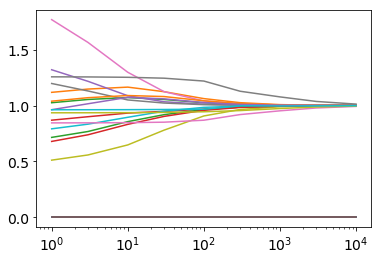

In [56]:
fig, ax = plt.subplots()
for param_list in param_lol:
    ax.plot(lbdas, param_list)
ax.set_xscale('log')

In [57]:
x0 = pampmw0 + subpen0 + subtrans0 + delpen0 + inspen0 + insweight0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = x[i-1]
fit['Cas12a Single Effects'] = minimize(chi_squared, x0, args=(cas12a_data, 4), method='Powell', options={'maxiter': 40000})

In [58]:
x0 = pampmw0 + subpen0 + subtrans0 + delpen0 + inspen0 + insweight0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = x[i-1]
        
lbdas = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000]
results = [
    minimize(chi_squared, x0, args=(cas12a_data, 4, 1, single_effects, lbda), method='Powell', options={'maxiter': 40000})
    for lbda in lbdas
]

In [59]:
parsed_params = parse_params(results[0].x, 4, 1, single_effects)
subtrans = parsed_params[2]
insw = parsed_params[-1]

param_lol = [[pp] for pp in list(subtrans.flatten()) + list(insw)]
for res in results[1:]:
    parsed_params = parse_params(res.x, 4, 1, single_effects)
    subtrans = parsed_params[2]
    insw = parsed_params[-1]
    for i, pp in enumerate(list(subtrans.flatten()) + list(insw)):
        param_lol[i].append(pp)

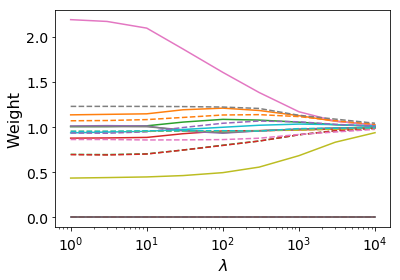

In [68]:
fig, ax = plt.subplots()
for i, param_list in enumerate(param_lol):
    if i > 9:
        ls = '--'
    else:
        ls = '-'
    ax.plot(lbdas, param_list, label=label, ls=ls)
ax.set_xscale('log')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Weight')
fig.savefig('figs/cas12a_lambdas.eps')
fig.savefig('figs/cas12a_lambdas.png', dpi=300)

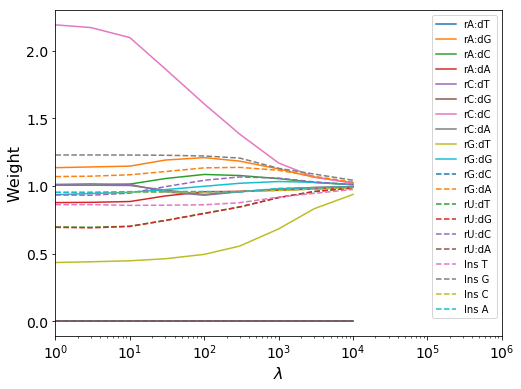

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))
labels = [
    'r{}:d{}'.format(rb, db)  for rb in 'ACGU' for db in 'TGCA'
] + [
    'Ins {}'.format(db) for db in 'TGCA'
]
for i, (param_list, label) in enumerate(zip(param_lol, labels)):
    if i > 9:
        ls = '--'
    else:
        ls = '-'
    ax.plot(lbdas, param_list, label=label, ls=ls)
ax.set_xscale('log')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Weight')
ax.set_xlim((1, 1e6))
ax.legend()
fig.savefig('figs/cas12a_lambdas_legend.eps')
fig.savefig('figs/cas12a_lambdas_legend.png', dpi=300)

In [276]:
res = fit['Cas12a Single Effects']

In [62]:
# Type of solver. Should be one of
#  'Nelder-Mead' 
#  'Powell' 
#  'CG' 
#  'BFGS' 
#  'Newton-CG' 
#  'L-BFGS-B' 
#  'TNC' 
#  'COBYLA' 
#  'SLSQP' 
#  'trust-constr'
#  'dogleg' 
#  'trust-ncg' 
#  'trust-exact' 
#  'trust-krylov' 

In [63]:
print 'Fit Success:', res.success
print 'Function Evals:', res.nfev
#print '{} of {} same'.format(sum(np.isclose(x0, res.x)), len(res.x))

Fit Success: True
Function Evals: 8202


In [64]:
parse_params(res.x, 4)

(array([[ -0.99310188,  -1.32641384,  -2.86548353,  15.52757377],
        [ -1.03206389,  -0.85809131,  -1.04974136,  -0.29680658],
        [ -1.12560801,  -2.08646264,  -2.62867118,  -0.31510758],
        [ 15.52757377,  15.52757377,  15.52757377,  -1.26171507]]),
 [-1.5546921031771401,
  -1.844040156388419,
  -1.3972978542644963,
  -1.9447974327242084,
  -2.312792210648972,
  -2.5030487919737925,
  -2.315963936801773,
  -1.4793092394267104,
  -1.0241530952045088,
  -1.021546579591357,
  -1.0102687921813467,
  -1.3009473908386444,
  -1.3566851368607802,
  -1.1022115484450485,
  -1.0935780402685538,
  -1.055394727611066,
  -0.96839793816491571,
  -0.45046838547659307,
  -0.13375828265094247,
  0.03930662524212588,
  -0.083489939935284946,
  0.04223381521272189,
  0.0032175233724152379],
 array([[ 0.        ,  1.12677425,  1.05514063,  0.969474  ],
        [ 0.97662014,  0.        ,  1.17035364,  0.97816834],
        [ 0.68362319,  1.03369774,  0.        ,  1.1167904 ],
        [ 0.9152

# Cas12a

## Fit vs. Measured Correlation

In [65]:
from scipy.stats import pearsonr, gaussian_kde

In [75]:
if not os.path.exists('figs'):
    os.mkdir('figs')

In [66]:
def print_minus_zeros_r(x, y):
    zero_zero, x_zero, zero_y = 0, 0, 0
    new_x, new_y = [], []
    for xx, yy in zip(x, y):
        if xx <= 0 and yy <= 0:
            zero_zero += 1
        elif yy <= 0:
            x_zero += 1
        elif xx <= 0:
            zero_y += 1
        else:
            new_x.append(xx)
            new_y.append(yy)
    r, pval = pearsonr(new_x, new_y)
    print 'Removed {:,d} / {:,d} / {:,d} of {:,d} values ({:.1f}%) with (x, 0) / (0, 0) / (0, y). r = {:.2f}'.format(
        x_zero, zero_zero, zero_y, len(x), float(x_zero + zero_zero + zero_y)/len(x) * 100, r
    )

In [67]:
def density_color(x, y):
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)
    return kernel(values)

In [68]:
def split_data(x, y):
    zbl, ztr = 0, 0
    zxr, zxl, zyb, zyt = [], [], [], []
    new_x, new_y = [], []
    not_corner_x, not_corner_y = [], []
    for xx, yy in zip(x, y):
        if xx <= log10_lb and yy <= log10_lb:
            zbl += 1
            continue
        elif xx >= log10_ub and yy >= log10_ub:
            ztr += 1
            continue
            
        not_corner_x.append(xx)
        not_corner_y.append(yy)
        if xx <= log10_lb:
            zxl.append(yy)
        elif xx >= log10_ub:
            zxr.append(yy)
        elif yy <= log10_lb:
            zyb.append(xx)
        elif yy >= log10_ub:
            zyt.append(xx)
        else:
            assert log10_lb < xx < log10_ub and log10_lb < yy < log10_ub
            new_x.append(xx)
            new_y.append(yy)
    return zbl, ztr, zxr, zxl, zyb, zyt, new_x, new_y, not_corner_x, not_corner_y
    

def get_all_meas_and_fit(x, loc_data, pamlen, del_trunc, model_func):
    meas_and_fit_cleavage_rates = build_measured_and_fit_cleavage_rates(x, loc_data, pamlen, del_trunc, model_func)
    all_meas, all_fit = [], []
    for run, cleavage_rates in sorted(meas_and_fit_cleavage_rates.items()):
        prot, tname, rep = run
        meas = cleavage_rates['meas']
        fit = cleavage_rates['fit']
        all_meas.extend(meas)
        all_fit.extend(fit)
    return all_meas, all_fit


def fit_v_meas_plot(x, loc_data, pamlen, del_trunc=1, model_func=single_effects):
    width_ratios = [1, 6, 1]
    height_ratios = [1, 6, 1]
    gs = mpl.gridspec.GridSpec(3, 3, width_ratios=width_ratios, height_ratios=height_ratios, 
                               wspace=0.1, hspace=0.1,
                               bottom=0.0, top=1.0, left=0.0, right=1.0)
    fig = plt.figure(figsize=(sum(width_ratios), sum(height_ratios)))

    all_meas, all_fit = get_all_meas_and_fit(x, loc_data, pamlen, del_trunc, model_func)
    zbl, ztr, zxr, zxl, zyb, zyt, new_x, new_y, not_corner_x, not_corner_y = split_data(all_meas, all_fit)
    r, pval = pearsonr(all_meas, all_fit)
    center_r, _ = pearsonr(new_x, new_y)
    not_corner_r, _ = pearsonr(not_corner_x, not_corner_y)
    lim = (log10_lb - 1, log10_ub + 1)

    # Corners
    ax = plt.subplot(gs[2])
    ax.text(0, 0, '$(ub, ub)$\n$%.0f$%%' % (100*float(ztr)/len(all_meas)), 
            fontsize=16, ha='center', va='center')
    ax = plt.subplot(gs[6])
    ax.text(0, 0, '$(lb, lb)$\n$%.0f$%%' % (100*float(zbl)/len(all_meas)), 
            fontsize=16, ha='center', va='center')
    for idx in [0, 2, 6, 8]:
        ax = plt.subplot(gs[idx])
        ax.set_xticks([]); ax.set_yticks([])
        ax.axis('off')
        ax.set_xlim((-0.5, 0.2))
        ax.set_ylim((-0.5, 0.2))
    

    # Correlation Plot
    ax = plt.subplot(gs[4])
    #ax.hexbin(new_x, new_y, gridsize=30, cmap='Greys', mincnt=1, vmin=0, vmax=0.005*len(new_x))
    ax.scatter(new_x, new_y, c=density_color(new_x, new_y), cmap='viridis', edgecolors='none')
    #ax.scatter(all_meas, all_fit, c=density_color(all_meas, all_fit), cmap='viridis', edgecolors='none')
    ax.text((lim[0] + lim[1])/2, (11*lim[0] + lim[1])/12, '$r = %.2f,\ r_c = %.2f,\ r_{nc} = %.2f$' % (r, center_r, not_corner_r), 
            fontsize=18, ha='center', va='center')
    ax.set_aspect(1)
    ax.legend(loc='lower right')

    ax.plot(lim, lim, 'k--', alpha=0.5)
    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    # hist stuff
    max_pct = 20
    h = float(max_pct)/100 * len(all_meas)
    loc_frac = 0.85
    nbins = 30
    text_pos = log10_lb + 1*data_span
    
    # XL hist
    ax = plt.subplot(gs[3])
    bins = np.linspace(lim[0], lim[1], nbins)
    ax.hist(zxl, bins, histtype='step', orientation='horizontal', color='grey')
    ax.set_xlim((h, 0))
    ax.set_xticklabels([]); 
    ax.set_xticks((0, h))
    ax.set_xticklabels((0, '{}%'.format(max_pct)))
    #ax.set_xlabel('$(0, y)$')
    ax.set_ylim(lim)
    ax.text(h/2, text_pos, '$(lb, y)$\n$%.0f$%%' % (100*float(len(zxl))/len(all_meas)), 
            fontsize=16, ha='center', va='center')
    ax.set_ylabel('Fit log10 Cleavage Rate ($s^{-1}$)')
    
    # XR hist
    ax = plt.subplot(gs[5])
    bins = np.linspace(lim[0], lim[1], nbins)
    ax.hist(zxr, bins, histtype='step', orientation='horizontal', color='grey')
    ax.set_xlim((0, h))
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_xticks((0, h))
    ax.set_xticklabels((0, '{}%'.format(max_pct)))
    #ax.set_xlabel('$(0, y)$')
    ax.set_ylim(lim)
    ax.text(h/2, text_pos, '$(ub, y)$\n$%.0f$%%' % (100*float(len(zxr))/len(all_meas)), 
            fontsize=16, ha='center', va='center')
    
    # YB hist
    ax = plt.subplot(gs[7])
    bins = np.linspace(lim[0], lim[1], nbins)
    ax.hist(zyb, bins, histtype='step', color='grey')
    ax.set_ylim((h, 0))
    ax.set_yticks((0, h))
    ax.set_yticklabels([])
    ax.set_yticklabels((0, '{}%'.format(max_pct)))
    #ax.set_ylabel('$(x, 0)$')
    ax.set_xlim(lim)
    ax.text(text_pos, h/2, '$(x, lb)$\n$%.0f$%%' % (100*float(len(zyb))/len(all_meas)), 
            fontsize=16, ha='center', va='center')
    ax.set_xlabel('Measured log10 Cleavage Rate ($s^{-1}$)')

    # YT hist
    ax = plt.subplot(gs[1])
    bins = np.linspace(lim[0], lim[1], nbins)
    ax.hist(zyt, bins, histtype='step', color='grey')
    ax.set_ylim((0, h))
    ax.set_yticks((0, h))
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_yticklabels((0, '{}%'.format(max_pct)))
    #ax.set_ylabel('$(x, 0)$')
    ax.set_xlim(lim)
    ax.text(text_pos, h/2, '$(x, ub)$\n$%.0f$%%' % (100*float(len(zyt))/len(all_meas)), 
            fontsize=16, ha='center', va='center')

    print_minus_zeros_r(all_meas, all_fit)
    return fig, ax

In [216]:
def no_edits_out_of_range(tup):
    run, seq, pam_cro, sub_cro, del_cro, ins_cro, cleavage_rate_tup = tup
    for i, r, o in sub_cro + del_cro + ins_cro:
        if i >= 20:
            return False
    return True

In [736]:
def split_data(x, y):
    zbl, ztr = 0, 0
    zxr, zxl, zyb, zyt = [], [], [], []
    new_x, new_y = [], []
    not_corner_x, not_corner_y = [], []
    for xx, yy in zip(x, y):
        if xx <= log10_lb and yy <= log10_lb:
            zbl += 1
            continue
        elif xx >= log10_ub and yy >= log10_ub:
            ztr += 1
            continue
            
        not_corner_x.append(xx)
        not_corner_y.append(yy)
        if xx <= log10_lb:
            zxl.append(yy)
        elif xx >= log10_ub:
            zxr.append(yy)
        elif yy <= log10_lb:
            zyb.append(xx)
        elif yy >= log10_ub:
            zyt.append(xx)
        else:
            assert log10_lb < xx < log10_ub and log10_lb < yy < log10_ub
            new_x.append(xx)
            new_y.append(yy)
    return zbl, ztr, zxr, zxl, zyb, zyt, new_x, new_y, not_corner_x, not_corner_y
    

def get_all_meas_and_fit(x, loc_data, pamlen, del_trunc, model_func):
    meas_and_fit_cleavage_rates = build_measured_and_fit_cleavage_rates(x, loc_data, pamlen, del_trunc, model_func)
    all_meas, all_fit = [], []
    for run, cleavage_rates in sorted(meas_and_fit_cleavage_rates.items()):
        prot, tname, rep = run
        meas = cleavage_rates['meas']
        fit = cleavage_rates['fit']
        all_meas.extend(meas)
        all_fit.extend(fit)
    return all_meas, all_fit


def explain_var(meas, fit):
    tv = np.std(meas)**2
    rv = np.std([mv - fv for mv, fv in zip(meas, fit)])**2
    pct_expl = 100*(tv - rv)/tv
    return tv, rv, pct_expl


def fit_v_meas_plot(x, loc_data, pamlen, del_trunc=1, model_func=single_effects, cmap='Purples'):
    width_ratios = [1, 10, 1]
    height_ratios = [1, 10, 1]
    gs = mpl.gridspec.GridSpec(3, 3, width_ratios=width_ratios, height_ratios=height_ratios, 
                               wspace=0.01, hspace=0.01,
                               bottom=0.0, top=1.0, left=0.0, right=1.0)
    fig = plt.figure(figsize=(3, 3))

    all_meas, all_fit = get_all_meas_and_fit(x, loc_data, pamlen, del_trunc, model_func)
    zbl, ztr, zxr, zxl, zyb, zyt, new_x, new_y, not_corner_x, not_corner_y = split_data(all_meas, all_fit)
    r, pval = pearsonr(all_meas, all_fit)
    center_r, _ = pearsonr(new_x, new_y)
    not_corner_r, _ = pearsonr(not_corner_x, not_corner_y)

    tv, rv, pct_expl = explain_var(all_meas, all_fit)
    print 'All Total variance: {:.1f}, Residual variance: {:.1f}, Percent explained: {:.1f}%'.format(tv, rv, pct_expl)
    tv, rv, pct_expl = explain_var(new_x, new_y)
    print 'Center Total variance: {:.1f}, Residual variance: {:.1f}, Percent explained: {:.1f}%'.format(tv, rv, pct_expl)
    
    lim = (log10_lb - 1, log10_ub + 1)
    
    v = [num_edits(tup) for tup in loc_data 
         if log10_ub > meas_and_fit_cleavage_rate_given_tup_and_params(tup, 
                                                                       x, 
                                                                       del_trunc=del_trunc,
                                                                       model_func=model_func)[1] > log10_lb
         and log10_ub > tup[-1][0] > log10_lb
         and no_edits_out_of_range(tup)]
    n_cntr = Counter(v)
    n_str = '\n'.join(['$n_%d = %s$' % (i, '{:,d}'.format(n_cntr[i])) for i in [0, 1, 2, 3]])
    n_str = '$n = {:,d}$'.format(len(v))


    # Corners
    ax = plt.subplot(gs[2])
    ax.text(0, 0, '$%.0f$%%' % (100*float(ztr)/len(all_meas)), 
            fontsize=12, ha='center', va='center')
    ax = plt.subplot(gs[6])
    ax.text(-0.2, -0.2, '$%.0f$%%' % (100*float(zbl)/len(all_meas)), 
            fontsize=12, ha='center', va='center')
    for idx in [0, 2, 6, 8]:
        ax = plt.subplot(gs[idx])
        ax.set_xticks([]); ax.set_yticks([])
        ax.axis('off')
        ax.set_xlim((-0.5, 0.2))
        ax.set_ylim((-0.5, 0.2))
    

    # Correlation Plot
    ax = plt.subplot(gs[4])
    ticks = [-1, -3, -5]
    hb = ax.hexbin(new_x, new_y, gridsize=10, cmap=cmap, mincnt=1, vmin=0)
#    ax.text((lim[0] + lim[1])/2, (11*lim[0] + lim[1])/12, '$r = %.2f$' % (r), 
#            fontsize=14, ha='center', va='center')
    ax.text((11*lim[0] + lim[1])/12, (lim[0] + 11*lim[1])/12, n_str + '\n' + '$r = %.2f$' % (r), 
            fontsize=14, ha='left', va='top')    
    ax.set_aspect(1)
    
    cax = fig.add_axes([0.54, 0.19, 0.3, 0.05])
    cbar = plt.colorbar(hb, cax=cax, orientation='horizontal')
    cticks = cbar.get_ticks()
    cticks = [cticks[0], cticks[-1]]
    cbar.set_ticks(cticks)
    

    ax.plot(lim, lim, 'k--', alpha=0.5)
    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    # hist stuff
    max_pct = 5
    h = float(max_pct)/100 * len(all_meas)
    loc_frac = 0.85
    nbins = 30
    text_pos = log10_lb + 1*data_span
    u_text_pos = log10_ub - data_span
    
    # XL hist
    ax = plt.subplot(gs[3])
    bins = np.linspace(lim[0], lim[1], nbins)
    ax.hist(zxl, bins, histtype='step', orientation='horizontal', color='grey')
    ax.set_xlim((h, 0))
    ax.set_xticklabels([]); 
    ax.set_xticks([])
#    ax.set_xticklabels((0, '{}%'.format(max_pct)))
    #ax.set_xlabel('$(0, y)$')
    ax.set_ylim(lim)
    ax.set_yticks(ticks)
    ax.set_yticklabels(['$10^{%d}$' % i for i in ticks])
    ax.text(h/2, text_pos, '$%.0f$%%' % (100*float(len(zxl))/len(all_meas)), 
            fontsize=12, ha='center', va='center', rotation=90)
    ax.set_ylabel('Fit Cleavage Rate ($s^{-1}$)')
    
    # XR hist
    ax = plt.subplot(gs[5])
    bins = np.linspace(lim[0], lim[1], nbins)
    ax.hist(zxr, bins, histtype='step', orientation='horizontal', color='grey')
    ax.set_xlim((0, h))
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_xticks([])
#    ax.set_xticklabels((0, '{}%'.format(max_pct)))
    #ax.set_xlabel('$(0, y)$')
    ax.set_ylim(lim)
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.text(h/2, u_text_pos, '$%.0f$%%' % (100*float(len(zxr))/len(all_meas)), 
            fontsize=12, ha='center', va='center', rotation=90)
    
    # YB hist
    ax = plt.subplot(gs[7])
    bins = np.linspace(lim[0], lim[1], nbins)
    ax.hist(zyb, bins, histtype='step', color='grey')
    ax.set_ylim((h, 0))
    ax.set_yticks([])
    ax.set_yticklabels([])
#    ax.set_yticklabels((0, '{}%'.format(max_pct)))
    #ax.set_ylabel('$(x, 0)$')
    ax.set_xlim(lim)
    ax.set_xticks(ticks)
    ax.set_xticklabels(['$10^{%d}$' % i for i in ticks])
    ax.text(text_pos, h/2, '$%.0f$%%' % (100*float(len(zyb))/len(all_meas)), 
            fontsize=12, ha='center', va='center')
    ax.set_xlabel('Measured Cleavage Rate ($s^{-1}$)')

    # YT hist
    ax = plt.subplot(gs[1])
    bins = np.linspace(lim[0], lim[1], nbins)
    ax.hist(zyt, bins, histtype='step', color='grey')
    ax.set_ylim((0, h))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xticklabels([]); ax.set_yticklabels([])
#    ax.set_yticklabels((0, '{}%'.format(max_pct)))
    ax.set_xlim(lim)
    ax.text(u_text_pos, h/2, '$%.0f$%%' % (100*float(len(zyt))/len(all_meas)), 
            fontsize=12, ha='center', va='center')

    print_minus_zeros_r(all_meas, all_fit)
    return fig, ax

In [704]:
single_edit_data = cas12a_single_edit_data
seqlen = 27
pamlen = 4
del_trunc = 1
tlen = seqlen - pamlen
pampmw0, _, _                          = initialize_PWM(2, pamlen, single_edit_data)
subpen0, _, _, _, subtrans0, _, _, _   = initialize_pen_and_trans(3, tlen, single_edit_data)
delpen0, _, _, _                       = initialize_pen(4, tlen-del_trunc, single_edit_data)
inspen0, _, _, _, insweight0, _, _ , _ = initialize_pen_and_weights(5, tlen, single_edit_data)

In [705]:
res = fit['Cas12a Single Effects']

All Total variance: 1.4, Residual variance: 0.3, Percent explained: 79.2%
Center Total variance: 1.0, Residual variance: 0.2, Percent explained: 77.5%
Removed 0 / 2,335 / 0 of 2,335 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



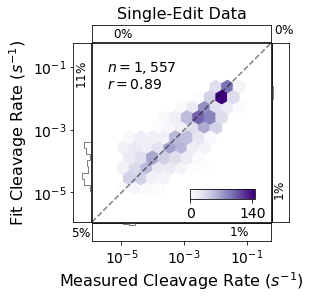

In [706]:
fig, ax = fit_v_meas_plot(res.x, cas12a_single_edit_data, 4)
ax.set_title('Single-Edit Data')
print

All Total variance: 1.2, Residual variance: 0.2, Percent explained: 80.7%
Center Total variance: 1.0, Residual variance: 0.3, Percent explained: 69.7%
Removed 0 / 22,172 / 0 of 22,172 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



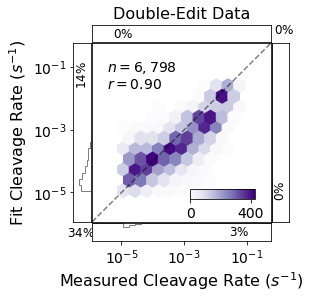

In [707]:
fig, ax = fit_v_meas_plot(res.x, cas12a_double_edit_data, 4)
ax.set_title('Double-Edit Data')
print

All Total variance: 1.2, Residual variance: 0.2, Percent explained: 82.8%
Center Total variance: 1.0, Residual variance: 0.3, Percent explained: 70.1%
Removed 0 / 26,477 / 0 of 26,477 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



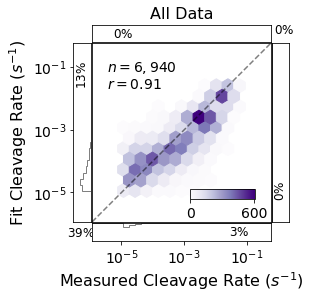

In [708]:
fig, ax = fit_v_meas_plot(res.x, cas12a_data, 4)
fig.savefig('figs/cas12a_model_correlation.eps')
fig.savefig('figs/cas12a_model_correlation.png', dpi=300)
ax.set_title('All Data')
print

## Distribution of Edit Counts

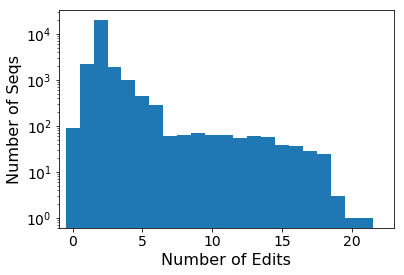

In [73]:
v = [num_edits(tup) for tup in cas12a_data]
bins = np.arange(23) - 0.5
fig, ax = plt.subplots()
ax.hist(v, bins)
ax.set_yscale('log')
ax.set_xlim((-1, 23))
ax.set_xlabel('Number of Edits')
ax.set_ylabel('Number of Seqs')
print

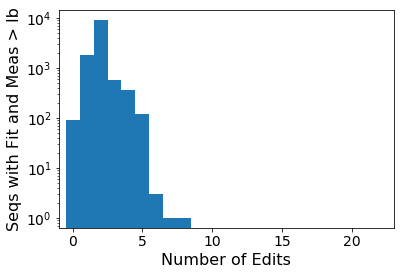

In [74]:
v = [num_edits(tup) for tup in cas12a_data
     if meas_and_fit_cleavage_rate_given_tup_and_params(tup, res.x, del_trunc=del_trunc)[1] > log10_lb
     and tup[-1][0] > log10_lb]
bins = np.arange(23) - 0.5
fig, ax = plt.subplots()
ax.hist(v, bins)
ax.set_yscale('log')
ax.set_xlim((-1, 23))
ax.set_xlabel('Number of Edits')
ax.set_ylabel('Seqs with Fit and Meas > lb')
print

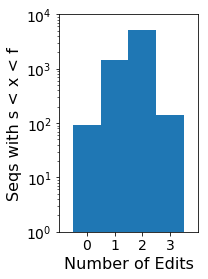

In [452]:
v = [num_edits(tup) for tup in cas12a_data 
     if log10_ub > meas_and_fit_cleavage_rate_given_tup_and_params(tup, res.x, del_trunc=del_trunc)[1] > log10_lb
     and log10_ub > tup[-1][0] > log10_lb
     and no_edits_out_of_range(tup)]
bins = np.arange(23) - 0.5
fig, ax = plt.subplots(figsize=(2.5, 4))
ax.hist(v, bins)
ax.set_yscale('log')
ax.set_xlim((-1, 4))
ax.set_xticks(range(4))
ax.set_xlabel('Number of Edits')
ax.set_ylabel('Seqs with s < x < f')
ax.set_ylim((1, 1e4))
fig.savefig('figs/cas12a_nedits.eps')
fig.savefig('figs/cas12a_nedits.png', dpi=300)
print

## Fit Parameters

In [76]:
def plot_params(params, pamlen, del_trunc=1, fname=None):
    pampwm, subpen, subtrans, delpen, inspen, insweight = parse_params(params, pamlen, del_trunc)
    tlen = len(subpen)
    width_ratios = [4, tlen/2.0]
    height_ratios = 3 * np.ones((3,))
    gs = mpl.gridspec.GridSpec(3, 2, width_ratios=width_ratios, height_ratios=height_ratios, 
                               wspace=0.3, hspace=0.5,
                               bottom=0.0, top=1.0, left=0.0, right=1.0)
    fig = plt.figure(figsize=(sum(width_ratios), sum(height_ratios)))

    for gs_idx, pen, ylabel in [(1, delpen, 'Del Rate ($s^{-1}$)'),
                                (3, subpen, 'Sub Weight'),
                                (5, inspen, 'Ins Rate ($s^{-1}$)')]:
        if gs_idx == 3:
            ylim = (-1.1, 0.1)
            lb = -1
            y = np.array(pen)/data_span
        else:
            ylim = (10**(-1.1*data_span), 10**(0.1*data_span))
            lb = 10**(-data_span)
            y = 10**np.array(pen)
        x = np.arange(1, len(pen) + 1)
        
        ax = plt.subplot(gs[gs_idx])
        ax.plot(x, y, 'o-', markersize=4)
        ax.set_xlabel('Target Position')
        ax.set_ylabel(ylabel)
        xlim = ax.get_xlim()
        ax.set_ylim(ylim)
        ax.plot(xlim, [0]*2, 'k:', zorder=-1, linewidth=1)
        ax.plot(xlim, [lb]*2, 'k:', zorder=-1, linewidth=1)
        if pamlen == 4:
            ax.set_xlim(xlim)
        else:
            ax.set_xlim(xlim[::-1])
        if gs_idx == 3:
            ax.set_yticks([0, -0.5, -1])
        else:
            ax.set_yscale('log')
    
    ax = plt.subplot(gs[0])
    ms = ax.matshow(-pampwm, cmap='OrRd', vmin=0)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticklabels(base_labels)
    ax.set_xlabel('PAM Position')
    ax.set_ylabel('Base')
    cbar = plt.colorbar(ms)
    cbar.set_label('PAM Penalty')
#    cbar.set_ticks([0, .25, .5, .75, 1])
    
    ax = plt.subplot(gs[2])
    subtrans[subtrans == 0] = np.nan
    diff = 0.6 #max(1 - np.nanmin(subtrans), np.nanmax(subtrans) - 1)
#    ms = ax.matshow(np.rot90(subtrans, k=2), vmin=1-diff, vmax=1+diff, cmap='coolwarm')
#    ms = ax.matshow(subtrans, vmin=1-diff, vmax=1+diff, cmap='coolwarm')
    M = 10**(np.fliplr(subtrans) * data_span)
    vmin = min(mm for mm in M.flatten() if mm > 0)
    vmax = max(mm for mm in M.flatten() if mm > 0)
    ms = ax.matshow(M, 
#                    norm=mpl.colors.LogNorm(vmin=10**((1-diff)*data_span), vmax=10**((1+diff)*data_span)), 
                    norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), 
                    cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(base_labels)
    ax.set_yticklabels(base_labels[:-1] + ['U'])
    ax.set_ylabel('RNA')
    ax.set_xlabel('TS DNA')
    cbar = plt.colorbar(ms)
    cbar.set_label('Sub Rate ($s^{-1}$)')
    #cbar.set_ticks([0.6*data_span, 1.0*data_span, 1.4*data_span])
    
    ax = plt.subplot(gs[4])
    #diff = max(1 - np.nanmin(insweight), np.nanmax(insweight) - 1)
    ms = ax.matshow(np.array([insweight])[::-1], vmin=1-diff, vmax=1+diff, cmap='coolwarm')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(base_labels)
    ax.set_yticks([])
    ax.set_xlabel('Inserted Base')
    ax.set_ylabel('')
    cbar = plt.colorbar(ms)
    cbar.set_label('Ins Weight')
    cbar.set_ticks([0.6, 1.0, 1.4])
    
    if fname:
        fname = os.path.join('figs', fname)
        fig.savefig(fname + '.eps')
        fig.savefig(fname + '.png', dpi=300)

In [77]:
def plot_params(params, pamlen, del_trunc=1, fname=None):
    pampwm, subpen, subtrans, delpen, inspen, insweight = parse_params(params, pamlen, del_trunc)
    tlen = len(subpen)
    width_ratios = [4, tlen/2.0]
    height_ratios = 3 * np.ones((3,))
    gs = mpl.gridspec.GridSpec(3, 2, width_ratios=width_ratios, height_ratios=height_ratios, 
                               wspace=0.3, hspace=0.5,
                               bottom=0.0, top=1.0, left=0.0, right=1.0)
    fig = plt.figure(figsize=(sum(width_ratios), sum(height_ratios)))

    for gs_idx, pen, ylabel in [(1, delpen, 'Del Rate ($s^{-1}$)'),
                                (3, subpen, 'Sub Rate ($s^{-1}$)'),
                                (5, inspen, 'Ins Rate ($s^{-1}$)')]:
        ylim = (10**(-1.1*data_span), 10**(0.1*data_span))
        lb = 10**(-data_span)
        y = 10**np.array(pen)
        x = np.arange(1, len(pen) + 1)
        
        ax = plt.subplot(gs[gs_idx])
        ax.plot(x, y, 'o-', markersize=4)
        ax.set_xlabel('Target Position')
        ax.set_ylabel(ylabel)
        xlim = ax.get_xlim()
        ax.set_ylim(ylim)
        ax.plot(xlim, [1]*2, 'k:', zorder=-1, linewidth=1)
        ax.plot(xlim, [lb]*2, 'k:', zorder=-1, linewidth=1)
        if pamlen == 4:
            ax.set_xlim(xlim)
        else:
            ax.set_xlim(xlim[::-1])
        ax.set_yscale('log')
    
    ax = plt.subplot(gs[0])
    ms = ax.matshow(-pampwm, cmap='OrRd', vmin=0)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticklabels(base_labels)
    ax.set_xlabel('PAM Position')
    ax.set_ylabel('Base')
    cbar = plt.colorbar(ms)
    cbar.set_label('PAM Penalty')
    
    ax = plt.subplot(gs[2])
    subtrans[subtrans == 0] = np.nan
    diff = 0.4 #max(1 - np.nanmin(subtrans), np.nanmax(subtrans) - 1)
    ms = ax.matshow(np.fliplr(subtrans), vmin=1-diff, vmax=1+diff, cmap='coolwarm')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(base_labels)
    ax.set_yticklabels(base_labels[:-1] + ['U'])
    ax.set_ylabel('gRNA')
    ax.set_xlabel('TS DNA')
    cbar = plt.colorbar(ms)
    cbar.set_label('Sub Weight')
    cbar.set_ticks([0.7, 1.0, 1.3])
    
    ax = plt.subplot(gs[4])
    ms = ax.matshow(np.array([insweight[::-1]]), vmin=1-diff, vmax=1+diff, cmap='coolwarm')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(base_labels)
    ax.set_yticks([])
    ax.set_xlabel('TS Inserted Base')
    ax.set_ylabel('')
    cbar = plt.colorbar(ms)
    cbar.set_label('Ins Weight')
    cbar.set_ticks([0.7, 1.0, 1.3])
    
    if fname:
        fname = os.path.join('figs', fname)
        fig.savefig(fname + '.eps')
        fig.savefig(fname + '.png', dpi=300)

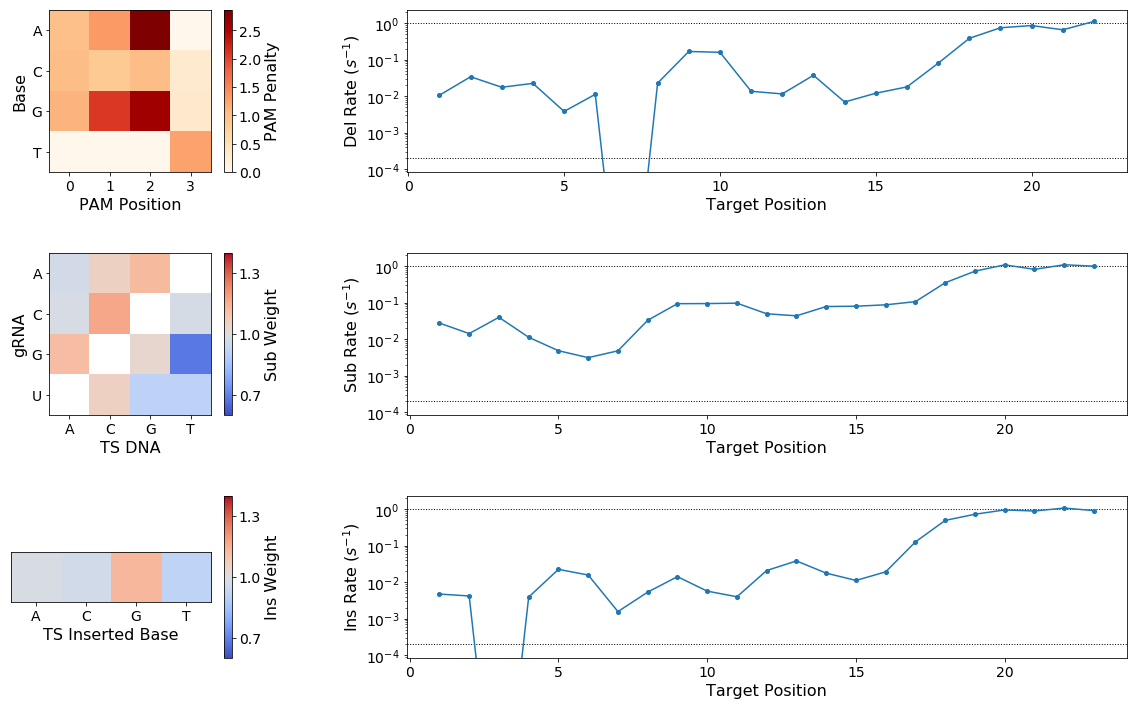

In [78]:
plot_params(res.x, 4, fname='cas12a_model')

# Cas9

In [471]:
single_edit_data = cas9_single_edit_data
seqlen = 27
pamlen = 3
del_trunc = 2
tlen = seqlen - pamlen
pampmw0, _, _                       = initialize_PWM(2, pamlen, single_edit_data)
subpen0, _, _, _, subtrans0, _, _, _   = initialize_pen_and_trans(3, tlen, single_edit_data)
delpen0, _, _, _                       = initialize_pen(4, tlen-del_trunc, single_edit_data)
inspen0, _, _, _, insweight0, _, _ , _ = initialize_pen_and_weights(5, tlen, single_edit_data)

In [80]:
x0 = pampmw0 + subpen0 + subtrans0 + delpen0 + inspen0 + insweight0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas9 Single Effects'] = minimize(chi_squared, x0, args=(single_edit_data, pamlen, del_trunc), method='Powell', options={'maxiter': 40000})

In [81]:
x0 = pampmw0 + subpen0 + subtrans0 + delpen0 + inspen0 + insweight0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas9 Single Effects'] = minimize(chi_squared, x0, args=(cas9_data, pamlen, del_trunc), method='Powell', options={'maxiter': 40000})

In [82]:
x0 = pampmw0 + subpen0 + subtrans0 + delpen0 + inspen0 + insweight0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = x[i-1]
        
lbdas = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000]
results = [
    minimize(chi_squared, x0, args=(cas9_data, pamlen, del_trunc, single_effects, lbda), method='Powell', options={'maxiter': 40000})
    for lbda in lbdas
]

In [83]:
parsed_params = parse_params(results[0].x, pamlen, del_trunc, single_effects)
subtrans = parsed_params[2]
insw = parsed_params[-1]

param_lol = [[pp] for pp in list(subtrans.flatten()) + list(insw)]
for res in results[1:]:
    parsed_params = parse_params(res.x, pamlen, del_trunc, single_effects)
    subtrans = parsed_params[2]
    insw = parsed_params[-1]
    for i, pp in enumerate(list(subtrans.flatten()) + list(insw)):
        param_lol[i].append(pp)

Text(0,0.5,'Weight')

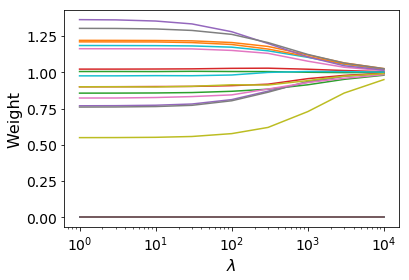

In [84]:
fig, ax = plt.subplots()
for param_list in param_lol:
    ax.plot(lbdas, param_list)
ax.set_xscale('log')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Weight')

In [469]:
res = fit['Cas9 Single Effects']

In [442]:
print 'Fit Success:', res.success
print 'Function Evals:', res.nfev

Fit Success: True
Function Evals: 8104


## Fit vs. Measured Correlation

In [759]:
cas9_cmap='Reds'

In [760]:
single_edit_data = cas9_single_edit_data
seqlen = 27
pamlen = 3
del_trunc = 2
tlen = seqlen - pamlen
pampmw0, _, _                       = initialize_PWM(2, pamlen, single_edit_data)
subpen0, _, _, _, subtrans0, _, _, _   = initialize_pen_and_trans(3, tlen, single_edit_data)
delpen0, _, _, _                       = initialize_pen(4, tlen-del_trunc, single_edit_data)
inspen0, _, _, _, insweight0, _, _ , _ = initialize_pen_and_weights(5, tlen, single_edit_data)

In [761]:
res = fit['Cas9 Single Effects']

All Total variance: 2.4, Residual variance: 0.2, Percent explained: 93.5%
Center Total variance: 1.1, Residual variance: 0.3, Percent explained: 76.6%
Removed 0 / 1,503 / 0 of 1,503 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



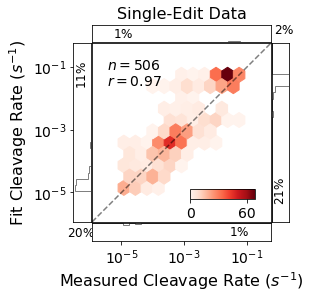

In [762]:
fig, ax = fit_v_meas_plot(res.x, cas9_single_edit_data, pamlen, del_trunc, cmap=cas9_cmap)
ax.set_title('Single-Edit Data')
print

All Total variance: 1.6, Residual variance: 0.1, Percent explained: 91.6%
Center Total variance: 0.9, Residual variance: 0.3, Percent explained: 66.4%
Removed 0 / 15,313 / 0 of 15,313 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



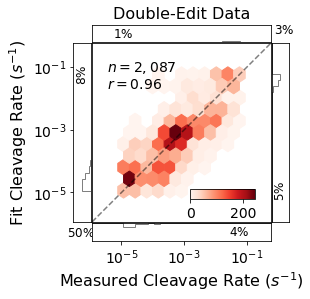

In [763]:
fig, ax = fit_v_meas_plot(res.x, cas9_double_edit_data, pamlen, del_trunc, cmap=cas9_cmap)
ax.set_title('Double-Edit Data')
print

All Total variance: 2.1, Residual variance: 0.1, Percent explained: 94.1%
Center Total variance: 1.0, Residual variance: 0.3, Percent explained: 67.3%
Removed 0 / 18,539 / 0 of 18,539 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



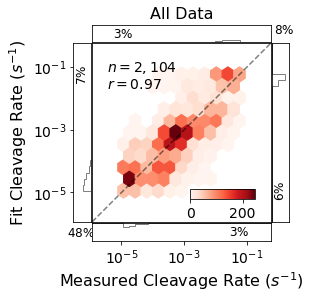

In [764]:
fig, ax = fit_v_meas_plot(res.x, cas9_data, pamlen, del_trunc, cmap=cas9_cmap)
fig.savefig('figs/{}_model_correlation.eps'.format(real_cas9_var))
fig.savefig('figs/{}_model_correlation.png'.format(real_cas9_var), dpi=300)
ax.set_title('All Data')
print

## Distribution of Edit Counts

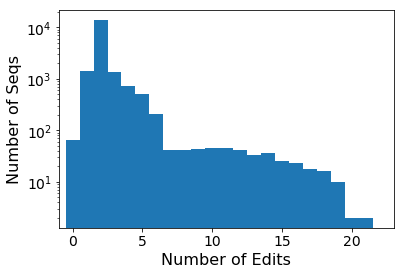

In [90]:
v = [num_edits(tup) for tup in cas9_data]
bins = np.arange(23) - 0.5
fig, ax = plt.subplots()
ax.hist(v, bins)
ax.set_yscale('log')
ax.set_xlim((-1, 23))
ax.set_xlabel('Number of Edits')
ax.set_ylabel('Number of Seqs')
print

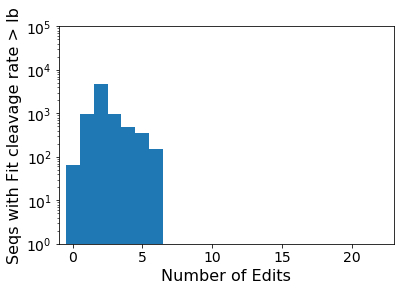

In [219]:
v = [num_edits(tup) for tup in cas9_data 
     if meas_and_fit_cleavage_rate_given_tup_and_params(tup, res.x, del_trunc=del_trunc)[1] > log10_lb
     and tup[-1][0] > log10_lb]
bins = np.arange(23) - 0.5
fig, ax = plt.subplots()
ax.hist(v, bins)
ax.set_yscale('log')
ax.set_xlim((-1, 23))
ax.set_xlabel('Number of Edits')
ax.set_ylabel('Seqs with Fit cleavage rate > lb')
ax.set_ylim((1, 1e5))
print

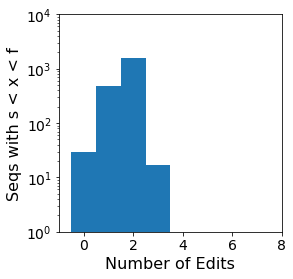

In [217]:
v = [num_edits(tup) for tup in cas9_data 
     if log10_ub > meas_and_fit_cleavage_rate_given_tup_and_params(tup, res.x, del_trunc=del_trunc)[1] > log10_lb
     and log10_ub > tup[-1][0] > log10_lb
     and no_edits_out_of_range(tup)]
bins = np.arange(23) - 0.5
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(v, bins)
ax.set_yscale('log')
ax.set_xlim((-1, 8))
ax.set_xlabel('Number of Edits')
ax.set_ylabel('Seqs with s < x < f')
ax.set_ylim((1, 1e4))
print

## Fit Parameters

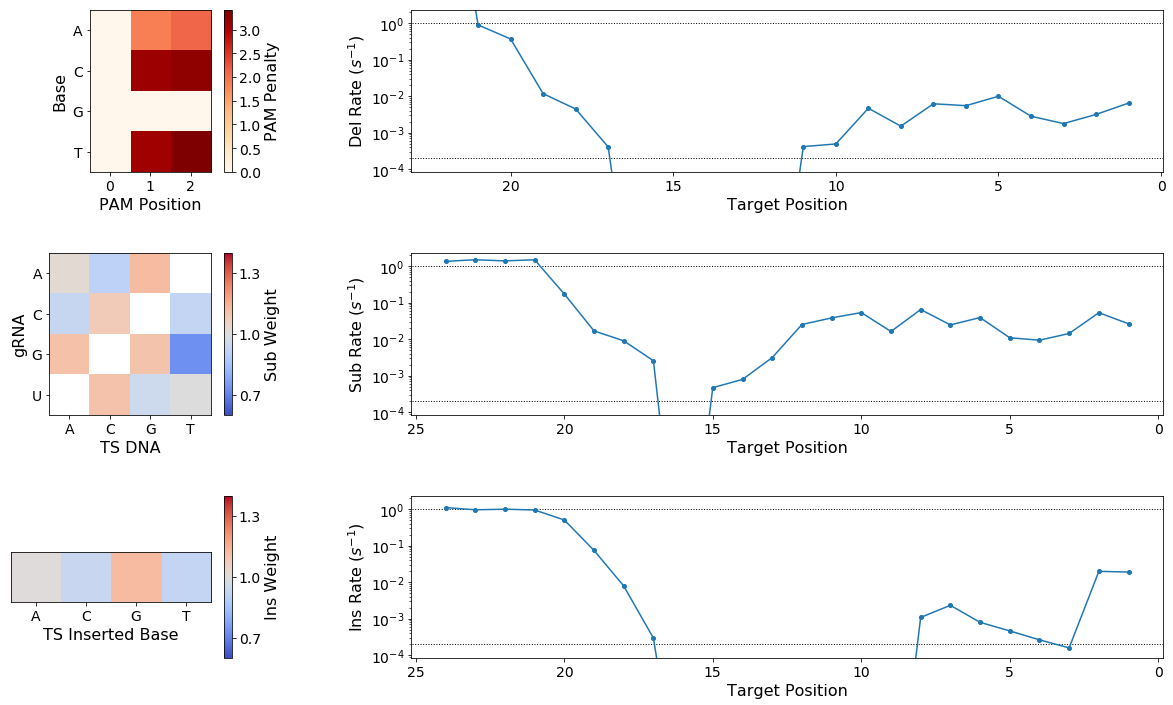

In [92]:
plot_params(res.x, 3, 2, fname='cas9_model')

# Simpler Models

For the sake of comparison, we wish to try a few simpler models and see how they affect correlation.

Simplest: PAM PWM and SubTrans Only (Unconstrained SubTrans)
\begin{align}
    CleavageRate = 
        & Perfect + \sum_{i \in PAM} PAMPen(i, s_i) \\
        &+ \sum_{i \in Target} SubTrans(r_i, s_i) \\
\end{align}


Next: PAM PWM and SubPen Only.
\begin{align}
     CleavageRate = 
        & Perfect + \sum_{i \in PAM} PAMPen(i, s_i) \\
        &+ \sum_{i \in Target} SubPen(i) \\
\end{align}

Next: PAM PWM and SubPen $\cdot$ SubTrans
\begin{align}
     CleavageRate = 
        & Perfect + \sum_{i \in PAM} PAMPen(i, s_i) \\
        &+ \sum_{i \in Target} SubPen(i) \cdot SubTrans(r_i, s_i) \\
\end{align}

Finally: All but InsWeight:
\begin{align}
     CleavageRate = 
        & Perfect + \sum_{i \in PAM} PAMPen(i, s_i) \\
        &+ \sum_{i \in Deletions} DelPen(i) \\
        &+ \sum_{i \in Insertions} InsPen(i) \\
        &+ \sum_{i \in Target} SubPen(i) \cdot SubTrans(r_i, s_i) \\
\end{align}


# Substitution only data

In [93]:
from adapters_cython import simple_hamming_distance

In [94]:
def hamming_with_offset(ref, seq, seq_offset):
    if seq_offset < 0:
        sdiff = len(seq) - seq_offset
        if sdiff < len(ref):
            # Ref:         ............................
            # Seq: .............................
            #      |offset|    sdiff            |
            return simple_hamming_distance(ref, seq[seq_offset:]) + len(ref) - sdiff
        else:
            # Ref:         ............................
            # Seq: ..........................................
            #      |offset|    sdiff                         |
            return simple_hamming_distance(ref, seq[seq_offset:])
    else:
        rdiff = len(ref) - seq_offset
        if rdiff < len(seq):
            # Ref: ............................
            # Seq:         .............................
            #      |offset|    rdiff           |
            return seq_offset + simple_hamming_distance(ref[seq_offset:], seq)
        else:
            # Ref: ............................
            # Seq:         .................
            #      |offset|    rdiff           |
            return seq_offset + simple_hamming_distance(ref[seq_offset:], seq) + rdiff - len(seq)

In [95]:
def build_sub_tuples(ref, seq):
    sub_tuples = []
    for i, rc, sc in enumerate(zip(ref, seq)):
        if rc != sc:
            sub_tuples.append((i, bases.index(rc), bases.index(sc)))
    return sub_tuples

def build_ins_tuples(start_i, seq):
    ins_tuples = []
    for i, sc in enumerate(seq):
        ins_tuples.append((start_i + i, '-', bases.index(sc)))
        
def build_del_tuples(start_i, ref):
    del_tuples = []
    for i, rc in enumerate(ref):
        del_tuples.append((start_i + i, bases.index(rc), '-'))

In [96]:
def subs_with_offset(ref, seq, seq_offset):
    if seq_offset < 0:
        sdiff = len(seq) - seq_offset
        if sdiff < len(ref):
            # Ref:         ............................
            # Seq: .............................
            #      |offset|    sdiff            |
            return build_sub_tuples(ref[:sdiff], seq[seq_offset:]) + build_del_tuples(sdiff, ref[sdiff:])
        else:
            # Ref:         ............................
            # Seq: ..........................................
            #      |offset|    sdiff                         |
            return build_sub_tuples(ref, seq[seq_offset:])
    else:
        rdiff = len(ref) - seq_offset
        if rdiff < len(seq):
            # Ref: ............................
            # Seq:         .............................
            #      |offset|    rdiff           |
            return build_del_tuples(0, ref[:seq_offset]) + build_sub_tuples(ref[seq_offset:], seq)
        else:
            # Ref: ............................
            # Seq:         .................
            #      |offset|    rdiff           |
            seq_end = seq_offset + len(seq)
            return build_del_tuples(0, ref[:seq_offset]) \
                    + build_sub_tuples(ref[seq_offset:], seq) \
                    + build_del_tuples(seq_end, ref[seq_end:])

In [97]:
def best_aligned_seq_and_hamming_dist(ref, seq):
    seq = (sp1 + seq)[-2*len(ref):]
    seq = (seq + sp2)[:3*len(ref)]
    best_start = min(range(2*len(ref)), key=lambda i: simple_hamming_distance(ref, seq[i:]))
    seq = seq[best_start:best_start + len(ref)]
    return seq, simple_hamming_distance(ref, seq)

def build_pam_sub_cros(prot, ref, aligned_seq):
    pam_cro, sub_cro = [], []
    if prot == 'Cas12a':
        for i in range(4):
            rc = ref[i]
            sc = aligned_seq[i]
            if rc != sc:
                pam_cro.append((i, bases.index(rc), bases.index(sc)))
        for i in range(4, len(ref)):
            rc = ref[i]
            sc = aligned_seq[i]
            if rc != sc:
                sub_cro.append((i-4, bases.index(rc), bases.index(sc)))
    else:
        assert prot == 'HF1', prot
        for i in range(3):
            ref_i = len(ref) - 3 + i
            rc = ref[ref_i]
            sc = aligned_seq[ref_i]
            if rc != sc:
                pam_cro.append((i, bases.index(rc), bases.index(sc)))
        for i in range(3, len(ref)):
            ref_i = len(ref) - i - 1
            rc = ref[ref_i]
            sc = aligned_seq[ref_i]
            if rc != sc:
                sub_cro.append((i-3, bases.index(rc), bases.index(sc)))
    return pam_cro, sub_cro

In [98]:
sub_data = []
for run, cleavage_rates_and_errs in norm_cleavage_rates_and_errs_given_run.items():
    perfect_target = perfect_targets[run]
    prot, tname, rep = run
    if prot == 'Cas12a':
        ref_pam = 'TTTA'
    else:
        assert prot == 'HF1', prot
        ref_pam = 'TGG'
    for seq, cleavage_rate_tup in cleavage_rates_and_errs.items():
        aligned_seq, best_ham = best_aligned_seq_and_hamming_dist(perfect_target, seq)
        pam_cro, sub_cro = build_pam_sub_cros(prot, perfect_target, aligned_seq)
        sub_data.append((run, seq, pam_cro, sub_cro, [], [], cleavage_rate_tup))

In [99]:
cas12a_sub_data = [tup for tup in sub_data if tup[0][0] == 'Cas12a']
cas9_sub_data = [tup for tup in sub_data if tup[0][0] == 'HF1']

In [100]:
len(sub_data), len(cas12a_sub_data), len(cas9_sub_data)

(45016, 26477, 18539)

In [101]:
cas12a_single_edit_sub_data = [tup for tup in cas12a_sub_data if sum(map(len, tup[2:6])) <= 1]
cas12a_double_edit_sub_data = [tup for tup in cas12a_sub_data if sum(map(len, tup[2:6])) <= 2]

In [102]:
len(cas12a_single_edit_sub_data), len(cas12a_double_edit_sub_data)

(1207, 12659)

In [103]:
cas9_single_edit_sub_data = [tup for tup in cas9_sub_data if sum(map(len, tup[2:6])) <= 1]
cas9_double_edit_sub_data = [tup for tup in cas9_sub_data if sum(map(len, tup[2:6])) <= 2]

In [104]:
len(cas9_single_edit_sub_data), len(cas9_double_edit_sub_data)

(881, 8856)

In [105]:
tup = random.choice(cas12a_single_edit_sub_data)
prot, tname, rep = tup[0]
seq = tup[1]
perfect_target = perfect_targets[tup[0]]
aligned_seq, best_ham = best_aligned_seq_and_hamming_dist(perfect_target, seq)
print '\n'.join([str(best_ham), perfect_target, aligned_seq])
tup

1
TTTAGACGCATAAAGATGAGACGCTGG
TTTAGACGCATAAAGATGAGACGCTAG


(('Cas12a', 'E', 1),
 'TTTAGACGCATAAAGATGAGACGCTAGCG',
 [],
 [(21, 2, 0)],
 [],
 [],
 (-2.5513126031164934, 0.0895665672919))

In [106]:
Counter(tup[0] for tup in cas12a_single_edit_sub_data)

Counter({('Cas12a', 'D', 1): 349,
         ('Cas12a', 'D', 2): 326,
         ('Cas12a', 'E', 1): 532})

In [107]:
Counter(tup[0] for tup in cas12a_double_edit_sub_data)

Counter({('Cas12a', 'D', 1): 4067,
         ('Cas12a', 'D', 2): 3802,
         ('Cas12a', 'E', 1): 4790})

In [108]:
tup = random.choice(cas9_single_edit_sub_data)
prot, tname, rep = tup[0]
seq = tup[1]
perfect_target = perfect_targets[tup[0]]
aligned_seq, best_ham = best_aligned_seq_and_hamming_dist(perfect_target, seq)
print '\n'.join([str(best_ham), perfect_target, aligned_seq])
tup

1
TTTAGACGCATAAAGATGAGACGCTGG
TTTAGACGCATAAAGATGAGACGCGGG


(('HF1', 'E', 1),
 'TTTAGACGCATAAAGATGAGACGCGGGTC',
 [(0, 3, 2)],
 [],
 [],
 [],
 (-1.4972257493219101, 0.33148168259))

In [109]:
Counter(tup[0] for tup in cas9_single_edit_sub_data)

Counter({('HF1', 'D', 1): 349, ('HF1', 'E', 1): 532})

In [110]:
Counter(tup[0] for tup in cas9_double_edit_sub_data)

Counter({('HF1', 'D', 1): 4067, ('HF1', 'E', 1): 4789})

# Cas12a

# PAM PWM and SubTrans Only

In [766]:
single_edit_data = cas12a_single_edit_sub_data
seqlen = 27
pamlen = 4
del_trunc = 1
tlen = seqlen - pamlen
pampmw0, _, _              = initialize_PWM(2, pamlen, single_edit_data)
nopen_subtrans0, _, _, _   = initialize_nopen_subtrans(3, tlen, single_edit_data)

In [112]:
x0 = pampmw0 + nopen_subtrans0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas12a PAMPWM SubTrans'] = minimize(chi_squared, x0, args=(cas12a_single_edit_sub_data, 4, del_trunc, pampwm_subtrans_model), 
               method='Powell', options={'maxiter': 40000})

In [113]:
x0 = pampmw0 + nopen_subtrans0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas12a PAMPWM SubTrans'] = minimize(chi_squared, x0, args=(cas12a_force_sub_data, 4, del_trunc, pampwm_subtrans_model), 
               method='Powell', options={'maxiter': 40000})

In [767]:
res = fit['Cas12a PAMPWM SubTrans']

In [768]:
print 'Fit Success:', res.success
print 'Function Evals:', res.nfev
#print '{} of {} same'.format(sum(np.isclose(x0, res.x)), len(res.x))

Fit Success: True
Function Evals: 2003


All Total variance: 1.4, Residual variance: 0.5, Percent explained: 62.3%
Center Total variance: 0.9, Residual variance: 0.4, Percent explained: 53.6%
Removed 0 / 1,207 / 0 of 1,207 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



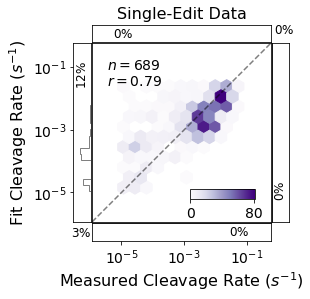

In [769]:
fig, ax = fit_v_meas_plot(res.x, cas12a_single_edit_sub_data, 4, del_trunc, pampwm_subtrans_model)
ax.set_title('Single-Edit Data')
print

All Total variance: 1.3, Residual variance: 1.2, Percent explained: 9.5%
Center Total variance: 1.0, Residual variance: 1.0, Percent explained: -5.9%
Removed 0 / 12,659 / 0 of 12,659 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



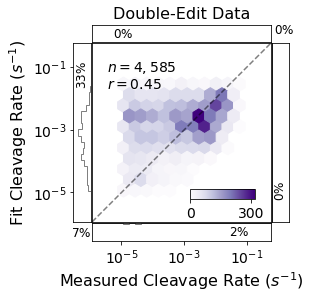

In [770]:
fig, ax = fit_v_meas_plot(res.x, cas12a_double_edit_sub_data, 4, del_trunc, pampwm_subtrans_model)
ax.set_title('Double-Edit Data')
print

All Total variance: 1.2, Residual variance: 1.0, Percent explained: 18.3%
Center Total variance: 1.0, Residual variance: 1.0, Percent explained: 0.6%
Removed 0 / 26,477 / 0 of 26,477 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



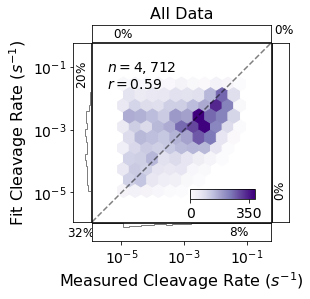

In [771]:
fig, ax = fit_v_meas_plot(res.x, cas12a_sub_data, 4, del_trunc, pampwm_subtrans_model)
ax.set_title('All Data')
print

All Total variance: 1.2, Residual variance: 1.0, Percent explained: 19.5%
Center Total variance: 1.0, Residual variance: 1.0, Percent explained: -3.7%
Removed 0 / 26,477 / 0 of 26,477 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



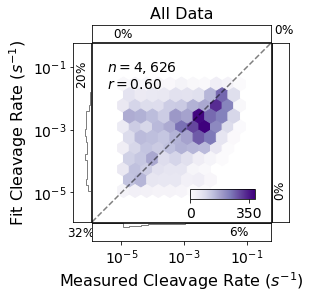

In [772]:
fig, ax = fit_v_meas_plot(res.x, cas12a_force_sub_data, 4, del_trunc, pampwm_subtrans_model)
fig.savefig('figs/cas12a_subtrans_model_correlation.eps')
fig.savefig('figs/cas12a_subtrans_model_correlation.png', dpi=300)
ax.set_title('All Data')
print

In [120]:
def plot_params_pampwm_subtrans(params, pamlen, del_trunc=1):
    pampwm, subtrans = parse_params(params, pamlen, del_trunc=del_trunc, model_func=pampwm_subtrans_model)
    width_ratios = [pamlen, 4]
    height_ratios = 3 * np.ones((1,))
    gs = mpl.gridspec.GridSpec(1, 2, width_ratios=width_ratios, height_ratios=height_ratios, 
                               wspace=0.5, hspace=0.5,
                               bottom=0.0, top=1.0, left=0.0, right=1.0)
    fig = plt.figure(figsize=(sum(width_ratios), sum(height_ratios)))

    ax = plt.subplot(gs[0])
    ms = ax.matshow(-pampwm, cmap='OrRd', vmin=0)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticklabels(base_labels)
    ax.set_xlabel('PAM Position')
    ax.set_ylabel('Base')
    cbar = plt.colorbar(ms)
    cbar.set_label('PAM Penalty')
#    cbar.set_ticks([0, .25, .5, .75, 1])
    
    ax = plt.subplot(gs[1])
    ms = ax.matshow(-subtrans, cmap='OrRd')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(base_labels); ax.set_yticklabels(base_labels)
    ax.set_xlabel('To')
    ax.set_ylabel('From')
    cbar = plt.colorbar(ms)
    cbar.set_label('Transition Penalty')
#    cbar.set_ticks([0, .25, .5, .75, 1])

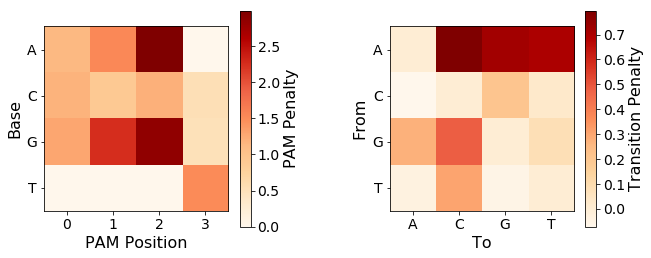

In [121]:
plot_params_pampwm_subtrans(res.x, 4)

## PAM PWM and SubPen Only

In [773]:
single_edit_data = cas12a_single_edit_sub_data
seqlen = 27
pamlen = 4
del_trunc = 1
tlen = seqlen - pamlen
pampmw0, _, _                       = initialize_PWM(2, pamlen, single_edit_data)
subpen0, _, _, _, subtrans0, _, _, _   = initialize_pen_and_trans(3, tlen, single_edit_data)

In [123]:
x0 = pampmw0 + subpen0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas12a PAMPWM SubPen'] = minimize(chi_squared, x0, args=(cas12a_single_edit_sub_data, 4, del_trunc, pampwm_subpen_model), 
               method='Powell', options={'maxiter': 40000})

In [124]:
x0 = pampmw0 + subpen0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas12a PAMPWM SubPen'] = minimize(chi_squared, x0, args=(cas12a_force_sub_data, 4, del_trunc, pampwm_subpen_model), 
               method='Powell', options={'maxiter': 40000})

In [774]:
res = fit['Cas12a PAMPWM SubPen']

In [775]:
print 'Fit Success:', res.success
print 'Function Evals:', res.nfev
#print '{} of {} same'.format(sum(np.isclose(x0, res.x)), len(res.x))

Fit Success: True
Function Evals: 3261


All Total variance: 1.4, Residual variance: 0.3, Percent explained: 75.9%
Center Total variance: 0.9, Residual variance: 0.2, Percent explained: 73.1%
Removed 0 / 1,207 / 0 of 1,207 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



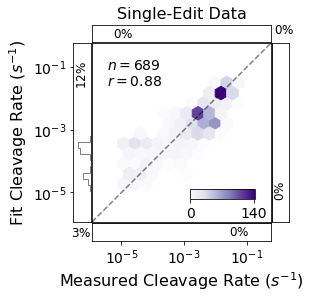

In [776]:
fig, ax = fit_v_meas_plot(res.x, cas12a_single_edit_sub_data, 4, del_trunc, pampwm_subpen_model)
ax.set_title('Single-Edit Data')
print

All Total variance: 1.3, Residual variance: 0.3, Percent explained: 75.4%
Center Total variance: 1.0, Residual variance: 0.4, Percent explained: 60.6%
Removed 0 / 12,659 / 0 of 12,659 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



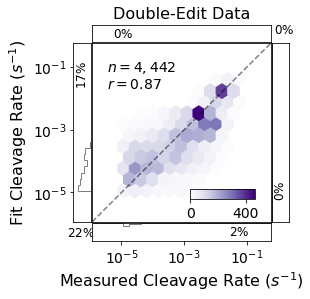

In [777]:
fig, ax = fit_v_meas_plot(res.x, cas12a_double_edit_sub_data, 4, del_trunc, pampwm_subpen_model)
ax.set_title('Double-Edit Data')
print

All Total variance: 1.2, Residual variance: 0.3, Percent explained: 72.7%
Center Total variance: 1.0, Residual variance: 0.4, Percent explained: 62.8%
Removed 0 / 26,477 / 0 of 26,477 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



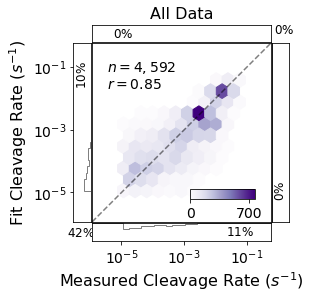

In [778]:
fig, ax = fit_v_meas_plot(res.x, cas12a_sub_data, 4, del_trunc, pampwm_subpen_model)
ax.set_title('All Data')
print

All Total variance: 1.2, Residual variance: 0.3, Percent explained: 72.1%
Center Total variance: 0.9, Residual variance: 0.3, Percent explained: 63.7%
Removed 0 / 26,477 / 0 of 26,477 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



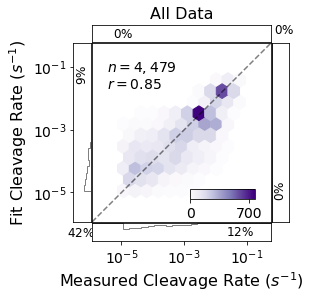

In [779]:
fig, ax = fit_v_meas_plot(res.x, cas12a_force_sub_data, 4, del_trunc, pampwm_subpen_model)
fig.savefig('figs/cas12a_subpen_model_correlation.eps')
fig.savefig('figs/cas12a_subpen_model_correlation.png', dpi=300)
ax.set_title('All Data')
print

In [131]:
def plot_params_pampwm_subpen(params, pamlen, del_trunc=1):
    pampwm, subpen = parse_params(params, pamlen, del_trunc=del_trunc, model_func=pampwm_subpen_model)
    tlen = len(subpen)
    width_ratios = [4, tlen/2.0]
    height_ratios = 3 * np.ones((1,))
    gs = mpl.gridspec.GridSpec(1, 2, width_ratios=width_ratios, height_ratios=height_ratios, 
                               wspace=0.3, hspace=0.5,
                               bottom=0.0, top=1.0, left=0.0, right=1.0)
    fig = plt.figure(figsize=(sum(width_ratios), sum(height_ratios)))

    ax = plt.subplot(gs[1])
    ax.plot(np.arange(1, len(subpen) + 1), np.array(subpen))
    ax.set_xlabel('Target Position')
    ax.set_ylabel('Sub Penalty')
    ax.set_ylim((-1.1*data_span, 0.1*data_span))
    
    ax = plt.subplot(gs[0])
    ms = ax.matshow(-pampwm, cmap='OrRd', vmin=0)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticklabels(base_labels)
    ax.set_xlabel('PAM Position')
    ax.set_ylabel('Base')
    cbar = plt.colorbar(ms)
    cbar.set_label('PAM Penalty')
#    cbar.set_ticks([0, .25, .5, .75, 1])

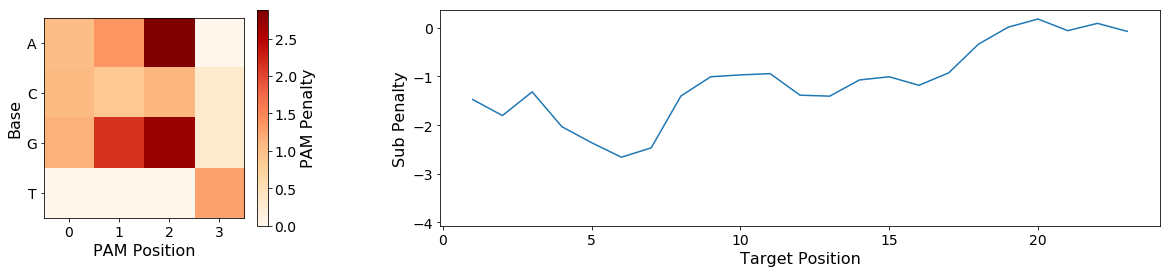

In [132]:
plot_params_pampwm_subpen(res.x, 4)

## PAM PWM, SubPen, SubTrans

In [133]:
x0 = pampmw0 + subpen0 + subtrans0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas12a PAMPWM SubPen SubTrans'] = minimize(chi_squared, x0, args=(cas12a_single_edit_sub_data, 4, del_trunc, pampwm_subpen_subtrans_model),
               method='Powell', options={'maxiter': 40000})

In [134]:
x0 = pampmw0 + subpen0 + subtrans0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas12a PAMPWM SubPen SubTrans'] = minimize(chi_squared, x0, args=(cas12a_force_sub_data, 4, del_trunc, pampwm_subpen_subtrans_model),
               method='Powell', options={'maxiter': 40000})

In [780]:
res = fit['Cas12a PAMPWM SubPen SubTrans']

In [781]:
print 'Fit Success:', res.success
print 'Function Evals:', res.nfev
#print '{} of {} same'.format(sum(np.isclose(x0, res.x)), len(res.x))

Fit Success: True
Function Evals: 3254


All Total variance: 1.4, Residual variance: 0.3, Percent explained: 76.7%
Center Total variance: 0.9, Residual variance: 0.2, Percent explained: 74.1%
Removed 0 / 1,207 / 0 of 1,207 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



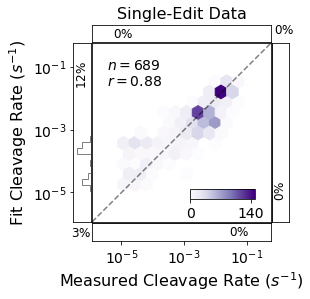

In [782]:
fig, ax = fit_v_meas_plot(res.x, cas12a_single_edit_sub_data, 4, del_trunc, pampwm_subpen_subtrans_model)
ax.set_title('Single-Edit Data')
print

All Total variance: 1.3, Residual variance: 0.3, Percent explained: 78.9%
Center Total variance: 1.0, Residual variance: 0.3, Percent explained: 66.7%
Removed 0 / 12,659 / 0 of 12,659 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



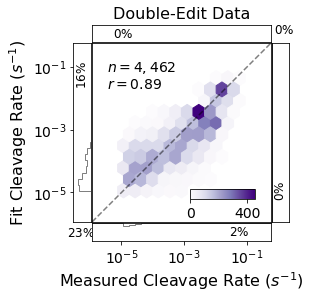

In [783]:
fig, ax = fit_v_meas_plot(res.x, cas12a_double_edit_sub_data, 4, del_trunc, pampwm_subpen_subtrans_model)
ax.set_title('Double-Edit Data')
print

All Total variance: 1.2, Residual variance: 0.3, Percent explained: 74.7%
Center Total variance: 0.9, Residual variance: 0.3, Percent explained: 67.5%
Removed 0 / 26,477 / 0 of 26,477 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



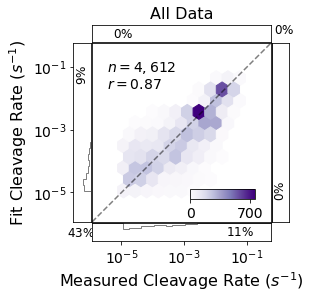

In [784]:
fig, ax = fit_v_meas_plot(res.x, cas12a_sub_data, 4, del_trunc, pampwm_subpen_subtrans_model)
ax.set_title('All Data')
print

All Total variance: 1.2, Residual variance: 0.3, Percent explained: 74.2%
Center Total variance: 0.9, Residual variance: 0.3, Percent explained: 68.6%
Removed 0 / 26,477 / 0 of 26,477 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



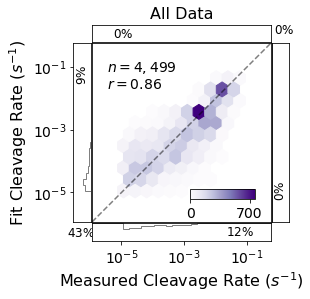

In [785]:
fig, ax = fit_v_meas_plot(res.x, cas12a_force_sub_data, 4, del_trunc, pampwm_subpen_subtrans_model)
fig.savefig('figs/cas12a_subtrans_subpen_model_correlation.eps')
fig.savefig('figs/cas12a_subtrans_subpen_model_correlation.png', dpi=300)
ax.set_title('All Data')
print

In [141]:
def plot_params_pampwm_subpen_subtrans(params, pamlen, del_trunc=1):
    pampwm, subpen, subtrans = parse_params(params, pamlen, del_trunc=del_trunc, model_func=pampwm_subpen_subtrans_model)
    tlen = len(subpen)
    width_ratios = [4, tlen/2.0]
    height_ratios = 3 * np.ones((2,))
    gs = mpl.gridspec.GridSpec(2, 2, width_ratios=width_ratios, height_ratios=height_ratios, 
                               wspace=0.3, hspace=0.5,
                               bottom=0.0, top=1.0, left=0.0, right=1.0)
    fig = plt.figure(figsize=(sum(width_ratios), sum(height_ratios)))

    for gs_idx, pen, ylabel in [(3, subpen, 'Sub Penalty')]:
        ax = plt.subplot(gs[gs_idx])
        ax.plot(np.arange(1, len(pen) + 1),np.array(pen))
        ax.set_xlabel('Target Position')
        ax.set_ylabel(ylabel)
        ax.set_ylim((-1.1*data_span, 0.1*data_span))
    
    ax = plt.subplot(gs[0])
    ms = ax.matshow(-pampwm, cmap='OrRd', vmin=0)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticklabels(base_labels)
    ax.set_xlabel('PAM Position')
    ax.set_ylabel('Base')
    cbar = plt.colorbar(ms)
    cbar.set_label('PAM Penalty')
#    cbar.set_ticks([0, .25, .5, .75, 1])
    
    ax = plt.subplot(gs[2])
    subtrans[subtrans == 0] = np.nan
    diff = 0.8 #max(1 - np.nanmin(subtrans), np.nanmax(subtrans) - 1)
    ms = ax.matshow(np.rot90(subtrans, k=2), vmin=1-diff, vmax=1+diff, cmap='coolwarm')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(base_labels); ax.set_yticklabels(base_labels)
    ax.set_ylabel('From')
    ax.set_xlabel('To')
    cbar = plt.colorbar(ms)
    cbar.set_label('Sub Weight')
    cbar.set_ticks([0.6, 1.0, 1.4])

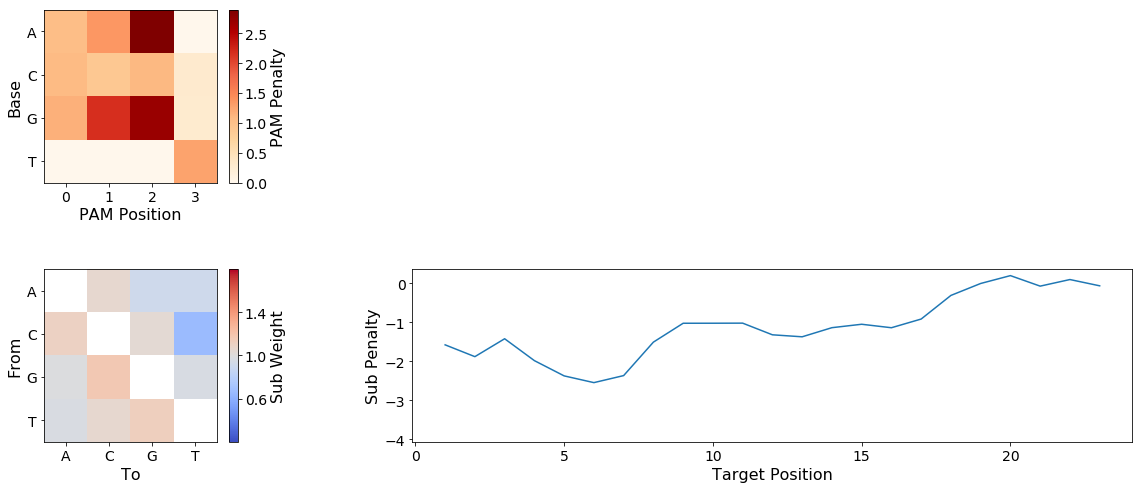

In [142]:
plot_params_pampwm_subpen_subtrans(res.x, 4)

## All but InsWeight

In [786]:
single_edit_data = cas12a_single_edit_data
seqlen = 27
pamlen = 4
del_trunc = 1
tlen = seqlen - pamlen
pampmw0, _, _                          = initialize_PWM(2, pamlen, single_edit_data)
subpen0, _, _, _, subtrans0, _, _, _   = initialize_pen_and_trans(3, tlen, single_edit_data)
delpen0, _, _, _                       = initialize_pen(4, tlen-del_trunc, single_edit_data)
inspen0, _, _, _, insweight0, _, _ , _ = initialize_pen_and_weights(5, tlen, single_edit_data)

In [144]:
x0 = pampmw0 + subpen0 + subtrans0 + delpen0 + inspen0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas12a All but InsWeight'] = minimize(chi_squared, x0, args=(cas12a_single_edit_data, 4, del_trunc, all_but_insweight),
               method='Powell', options={'maxiter': 40000})

In [145]:
x0 = pampmw0 + subpen0 + subtrans0 + delpen0 + inspen0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas12a All but InsWeight'] = minimize(chi_squared, x0, args=(cas12a_data, 4, del_trunc, all_but_insweight),
               method='Powell', options={'maxiter': 40000})

In [787]:
res = fit['Cas12a All but InsWeight']

All Total variance: 1.4, Residual variance: 0.3, Percent explained: 78.1%
Center Total variance: 1.0, Residual variance: 0.2, Percent explained: 76.6%
Removed 0 / 2,335 / 0 of 2,335 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



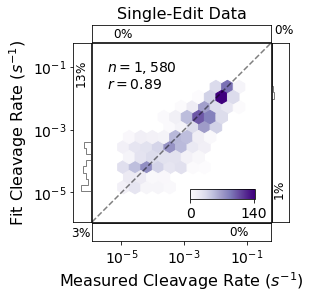

In [788]:
fig, ax = fit_v_meas_plot(res.x, cas12a_single_edit_data, 4, del_trunc, all_but_insweight)
ax.set_title('Single-Edit Data')
print

All Total variance: 1.2, Residual variance: 0.2, Percent explained: 80.2%
Center Total variance: 1.0, Residual variance: 0.3, Percent explained: 69.1%
Removed 0 / 22,172 / 0 of 22,172 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



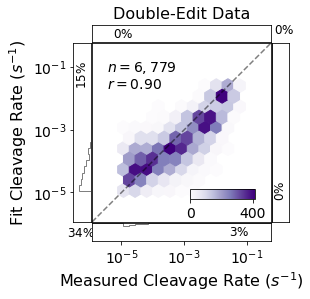

In [789]:
fig, ax = fit_v_meas_plot(res.x, cas12a_double_edit_data, 4, del_trunc, all_but_insweight)
ax.set_title('Double-Edit Data')
print

All Total variance: 1.2, Residual variance: 0.2, Percent explained: 82.4%
Center Total variance: 1.0, Residual variance: 0.3, Percent explained: 69.6%
Removed 0 / 26,477 / 0 of 26,477 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



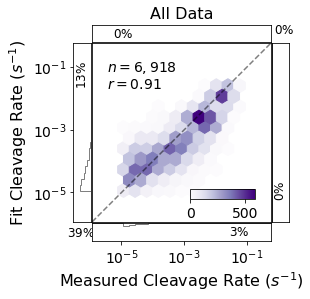

In [791]:
fig, ax = fit_v_meas_plot(res.x, cas12a_data, 4, del_trunc, all_but_insweight)
fig.savefig('figs/cas12a_all_but_insweight_model_correlation.eps')
fig.savefig('figs/cas12a_all_but_insweight_model_correlation.png', dpi=300)
ax.set_title('All Data')
print

In [150]:
def plot_params_all_but_insweight(params, pamlen, del_trunc=1):
    pampwm, subpen, subtrans, delpen, inspen = parse_params(params, pamlen, del_trunc=del_trunc, model_func=all_but_insweight)
    tlen = len(subpen)
    width_ratios = [4, tlen/2.0]
    height_ratios = 3 * np.ones((3,))
    gs = mpl.gridspec.GridSpec(3, 2, width_ratios=width_ratios, height_ratios=height_ratios, 
                               wspace=0.3, hspace=0.5,
                               bottom=0.0, top=1.0, left=0.0, right=1.0)
    fig = plt.figure(figsize=(sum(width_ratios), sum(height_ratios)))

    for gs_idx, pen, ylabel in [(1, delpen, 'Del Penalty'),
                                (3, subpen, 'Sub Penalty'),
                                (5, inspen, 'Ins Penalty')]:
        ax = plt.subplot(gs[gs_idx])
        ax.plot(np.arange(1, len(pen) + 1), np.array(pen))
        ax.set_xlabel('Target Position')
        ax.set_ylabel(ylabel)
        ax.set_ylim((-1.1*data_span, 0.1*data_span))
    
    ax = plt.subplot(gs[0])
    ms = ax.matshow(-pampwm, cmap='OrRd', vmin=0)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticklabels(base_labels)
    ax.set_xlabel('PAM Position')
    ax.set_ylabel('Base')
    cbar = plt.colorbar(ms)
    cbar.set_label('PAM Penalty')
#    cbar.set_ticks([0, .25, .5, .75, 1])
    
    ax = plt.subplot(gs[2])
    subtrans[subtrans == 0] = np.nan
    diff = 0.8 #max(1 - np.nanmin(subtrans), np.nanmax(subtrans) - 1)
    ms = ax.matshow(subtrans, vmin=1-diff, vmax=1+diff, cmap='coolwarm')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(base_labels); ax.set_yticklabels(base_labels)
    ax.set_ylabel('From')
    ax.set_xlabel('To')
    cbar = plt.colorbar(ms)
    cbar.set_label('Sub Weight')
    cbar.set_ticks([0.6, 1.0, 1.4])

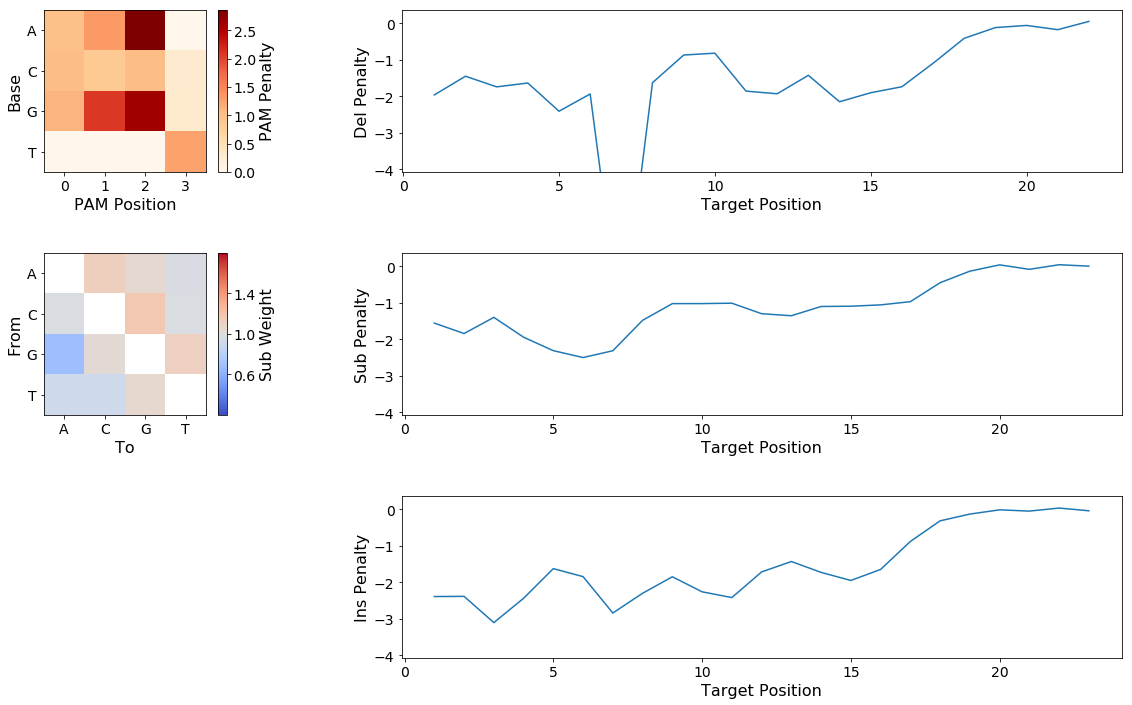

In [151]:
plot_params_all_but_insweight(res.x, 4)

# Cas9

# PAM PWM and SubTrans Only

In [792]:
single_edit_data = cas9_single_edit_sub_data
seqlen = 27
pamlen = 3
del_trunc = 2
tlen = seqlen - pamlen
pampmw0, _, _              = initialize_PWM(2, pamlen, single_edit_data)
nopen_subtrans0, _, _, _   = initialize_nopen_subtrans(3, tlen, single_edit_data)

In [153]:
x0 = pampmw0 + nopen_subtrans0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas9 PAMPWM SubTrans'] = minimize(chi_squared, x0, args=(cas9_single_edit_sub_data, pamlen, del_trunc, pampwm_subtrans_model), 
               method='Powell', options={'maxiter': 40000})

In [154]:
x0 = pampmw0 + nopen_subtrans0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas9 PAMPWM SubTrans'] = minimize(chi_squared, x0, args=(cas9_force_sub_data, pamlen, del_trunc, pampwm_subtrans_model), 
               method='Powell', options={'maxiter': 40000})

In [793]:
res = fit['Cas9 PAMPWM SubTrans']

In [794]:
print 'Fit Success:', res.success
print 'Function Evals:', res.nfev
#print '{} of {} same'.format(sum(np.isclose(x0, res.x)), len(res.x))

Fit Success: True
Function Evals: 1645


All Total variance: 1.8, Residual variance: 0.6, Percent explained: 67.0%
Center Total variance: 1.1, Residual variance: 0.6, Percent explained: 48.2%
Removed 0 / 881 / 0 of 881 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



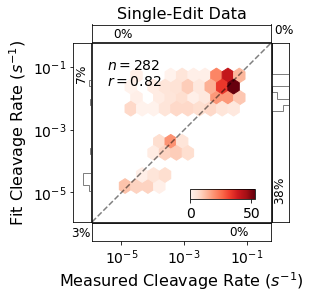

In [795]:
fig, ax = fit_v_meas_plot(res.x, cas9_single_edit_sub_data, pamlen, del_trunc, pampwm_subtrans_model, cmap=cas9_cmap)
ax.set_title('Single-Edit Data')
print

All Total variance: 2.0, Residual variance: 1.8, Percent explained: 13.5%
Center Total variance: 1.1, Residual variance: 1.1, Percent explained: -2.5%
Removed 0 / 8,856 / 0 of 8,856 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



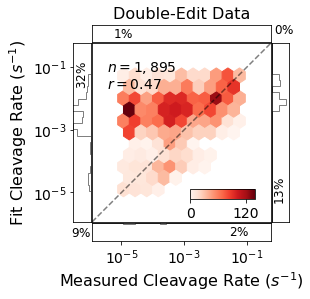

In [796]:
fig, ax = fit_v_meas_plot(res.x, cas9_double_edit_sub_data, pamlen, del_trunc, pampwm_subtrans_model, cmap=cas9_cmap)
ax.set_title('Double-Edit Data')
print

All Total variance: 2.1, Residual variance: 1.3, Percent explained: 37.5%
Center Total variance: 1.2, Residual variance: 1.1, Percent explained: 4.2%
Removed 0 / 18,539 / 0 of 18,539 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



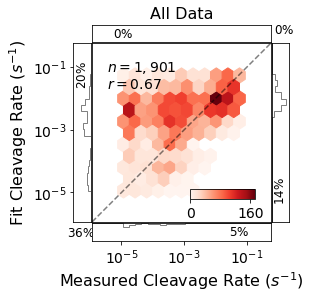

In [797]:
fig, ax = fit_v_meas_plot(res.x, cas9_sub_data, pamlen, del_trunc, pampwm_subtrans_model, cmap=cas9_cmap)
ax.set_title('All Data')
print

All Total variance: 2.1, Residual variance: 1.5, Percent explained: 27.4%
Center Total variance: 1.2, Residual variance: 1.1, Percent explained: 2.8%
Removed 0 / 18,539 / 0 of 18,539 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



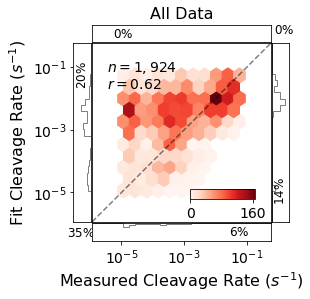

In [799]:
fig, ax = fit_v_meas_plot(res.x, cas9_force_sub_data, pamlen, del_trunc, pampwm_subtrans_model, cmap=cas9_cmap)
fig.savefig('figs/{}_subtrans_model_correlation.eps'.format(real_cas9_var))
fig.savefig('figs/{}_subtrans_model_correlation.png'.format(real_cas9_var), dpi=300)
ax.set_title('All Data')
print

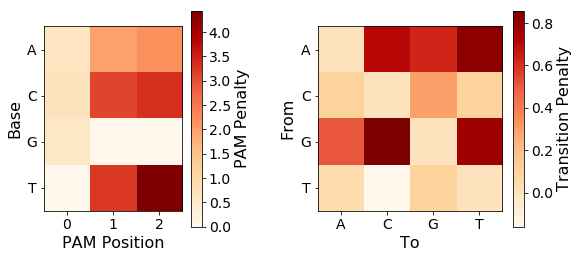

In [161]:
plot_params_pampwm_subtrans(res.x, pamlen, del_trunc)

## PAM PWM and SubPen Only

In [800]:
single_edit_data = cas9_single_edit_sub_data
seqlen = 27
pamlen = 3
del_trunc = 2
tlen = seqlen - pamlen
pampmw0, _, _                       = initialize_PWM(2, pamlen, single_edit_data)
subpen0, _, _, _, subtrans0, _, _, _   = initialize_pen_and_trans(3, tlen, single_edit_data)

In [163]:
x0 = pampmw0 + subpen0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas9 PAMPWM SubPen'] = minimize(chi_squared, x0, args=(single_edit_data, pamlen, del_trunc, pampwm_subpen_model), 
               method='Powell', options={'maxiter': 40000})

In [164]:
x0 = pampmw0 + subpen0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas9 PAMPWM SubPen'] = minimize(chi_squared, x0, args=(cas9_force_sub_data, pamlen, del_trunc, pampwm_subpen_model), 
               method='Powell', options={'maxiter': 40000})

In [801]:
res = fit['Cas9 PAMPWM SubPen']

In [802]:
print 'Fit Success:', res.success
print 'Function Evals:', res.nfev
#print '{} of {} same'.format(sum(np.isclose(x0, res.x)), len(res.x))

Fit Success: True
Function Evals: 2052


All Total variance: 1.8, Residual variance: 0.2, Percent explained: 89.9%
Center Total variance: 1.1, Residual variance: 0.3, Percent explained: 75.1%
Removed 0 / 881 / 0 of 881 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



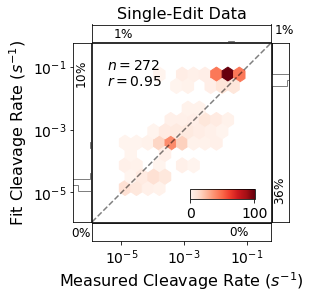

In [819]:
fig, ax = fit_v_meas_plot(res.x, cas9_single_edit_sub_data, pamlen, del_trunc, pampwm_subpen_model, cmap=cas9_cmap)
ax.set_title('Single-Edit Data')
print

All Total variance: 2.0, Residual variance: 0.2, Percent explained: 89.0%
Center Total variance: 0.9, Residual variance: 0.4, Percent explained: 56.9%
Removed 0 / 8,856 / 0 of 8,856 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



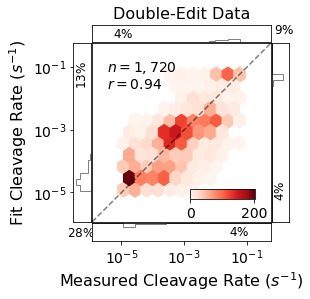

In [820]:
fig, ax = fit_v_meas_plot(res.x, cas9_double_edit_sub_data, pamlen, del_trunc, pampwm_subpen_model, cmap=cas9_cmap)
ax.set_title('Double-Edit Data')
print

All Total variance: 2.1, Residual variance: 0.2, Percent explained: 91.3%
Center Total variance: 0.9, Residual variance: 0.4, Percent explained: 53.3%
Removed 0 / 18,539 / 0 of 18,539 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



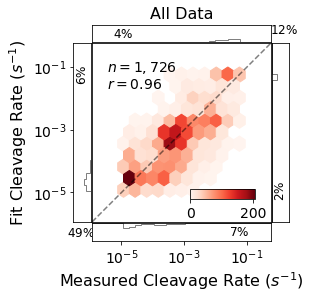

In [821]:
fig, ax = fit_v_meas_plot(res.x, cas9_sub_data, pamlen, del_trunc, pampwm_subpen_model, cmap=cas9_cmap)
ax.set_title('All Data')
print

All Total variance: 2.1, Residual variance: 0.4, Percent explained: 82.0%
Center Total variance: 0.9, Residual variance: 0.4, Percent explained: 54.0%
Removed 0 / 18,539 / 0 of 18,539 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



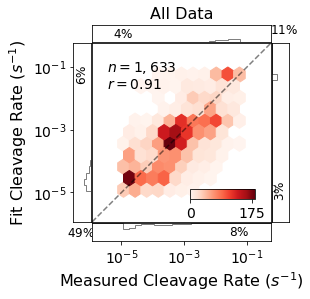

In [822]:
fig, ax = fit_v_meas_plot(res.x, cas9_force_sub_data, pamlen, del_trunc, pampwm_subpen_model, cmap=cas9_cmap)
fig.savefig('figs/{}_subpen_model_correlation.eps'.format(real_cas9_var))
fig.savefig('figs/{}_subpen_model_correlation.png'.format(real_cas9_var), dpi=300)
ax.set_title('All Data')
print

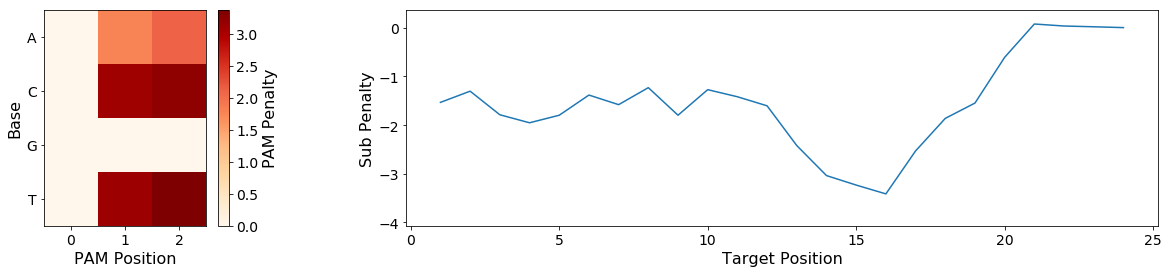

In [171]:
plot_params_pampwm_subpen(res.x, pamlen, del_trunc)

## PAM PWM, SubPen, SubTrans

In [172]:
x0 = pampmw0 + subpen0 + subtrans0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas9 PAMPWM SubPen SubTrans'] = minimize(chi_squared, x0, args=(cas9_single_edit_sub_data, pamlen, del_trunc, pampwm_subpen_subtrans_model),
               method='Powell', options={'maxiter': 40000})

In [173]:
x0 = pampmw0 + subpen0 + subtrans0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas9 PAMPWM SubPen SubTrans'] = minimize(chi_squared, x0, args=(cas9_force_sub_data, pamlen, del_trunc, pampwm_subpen_subtrans_model),
               method='Powell', options={'maxiter': 40000})

In [807]:
res = fit['Cas9 PAMPWM SubPen SubTrans']

In [808]:
print 'Fit Success:', res.success
print 'Function Evals:', res.nfev
#print '{} of {} same'.format(sum(np.isclose(x0, res.x)), len(res.x))

Fit Success: True
Function Evals: 2540


All Total variance: 1.8, Residual variance: 0.2, Percent explained: 90.8%
Center Total variance: 1.1, Residual variance: 0.3, Percent explained: 76.9%
Removed 0 / 881 / 0 of 881 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



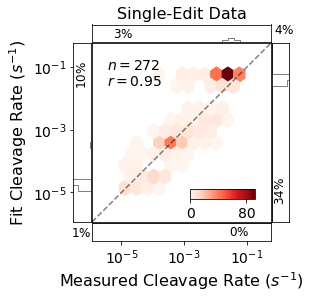

In [823]:
fig, ax = fit_v_meas_plot(res.x, cas9_single_edit_sub_data, pamlen, del_trunc, pampwm_subpen_subtrans_model, cmap=cas9_cmap)
ax.set_title('Single-Edit Data')
print

All Total variance: 2.0, Residual variance: 0.2, Percent explained: 91.6%
Center Total variance: 0.9, Residual variance: 0.3, Percent explained: 66.8%
Removed 0 / 8,856 / 0 of 8,856 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



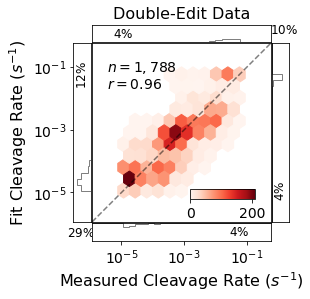

In [824]:
fig, ax = fit_v_meas_plot(res.x, cas9_double_edit_sub_data, pamlen, del_trunc, pampwm_subpen_subtrans_model, cmap=cas9_cmap)
ax.set_title('Double-Edit Data')
print

All Total variance: 2.1, Residual variance: 0.2, Percent explained: 92.5%
Center Total variance: 0.9, Residual variance: 0.3, Percent explained: 62.4%
Removed 0 / 18,539 / 0 of 18,539 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



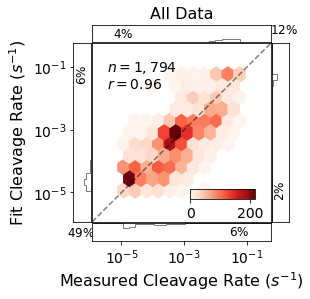

In [825]:
fig, ax = fit_v_meas_plot(res.x, cas9_sub_data, pamlen, del_trunc, pampwm_subpen_subtrans_model, cmap=cas9_cmap)
ax.set_title('All Data')
print

All Total variance: 2.1, Residual variance: 0.4, Percent explained: 83.2%
Center Total variance: 0.9, Residual variance: 0.3, Percent explained: 63.7%
Removed 0 / 18,539 / 0 of 18,539 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



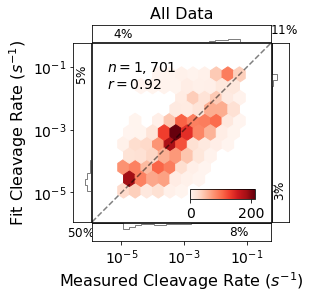

In [826]:
fig, ax = fit_v_meas_plot(res.x, cas9_force_sub_data, pamlen, del_trunc, pampwm_subpen_subtrans_model, cmap=cas9_cmap)
fig.savefig('figs/{}_subtrans_subpen_model_correlation.eps'.format(real_cas9_var))
fig.savefig('figs/{}_subtrans_subpen_model_correlation.png'.format(real_cas9_var), dpi=300)
ax.set_title('All Data')
print

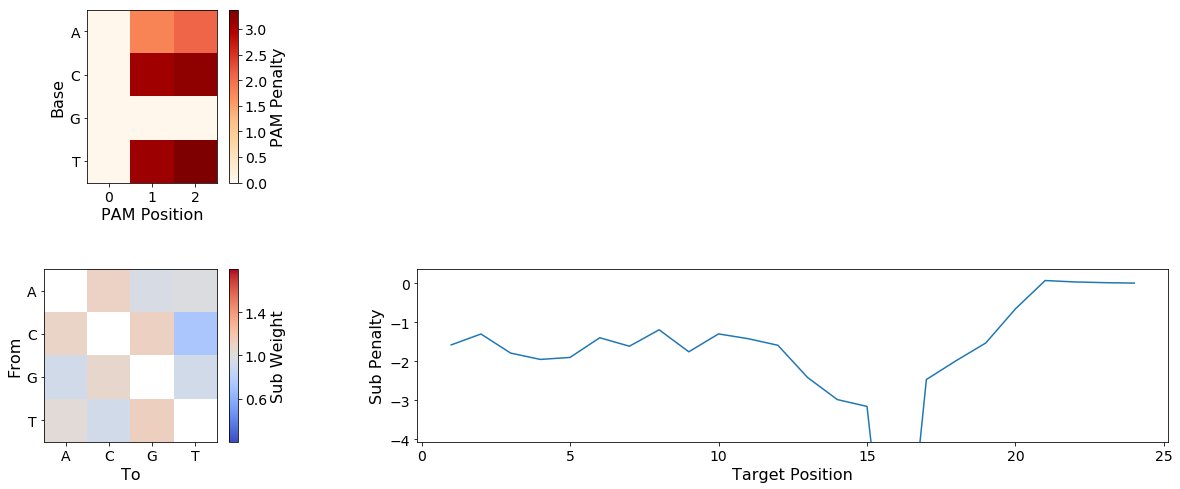

In [180]:
plot_params_pampwm_subpen_subtrans(res.x, pamlen, del_trunc)

## All but InsWeight

In [813]:
single_edit_data = cas9_single_edit_data
seqlen = 27
pamlen = 3
del_trunc = 2
tlen = seqlen - pamlen
pampmw0, _, _                       = initialize_PWM(2, pamlen, single_edit_data)
subpen0, _, _, _, subtrans0, _, _, _   = initialize_pen_and_trans(3, tlen, single_edit_data)
delpen0, _, _, _                       = initialize_pen(4, tlen-del_trunc, single_edit_data)
inspen0, _, _, _, insweight0, _, _ , _ = initialize_pen_and_weights(5, tlen, single_edit_data)

In [182]:
x0 = pampmw0 + subpen0 + subtrans0 + delpen0 + inspen0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas9 All but InsWeight'] = minimize(chi_squared, x0, args=(cas9_single_edit_data, pamlen, del_trunc, all_but_insweight),
               method='Powell', options={'maxiter': 40000})

In [183]:
x0 = pampmw0 + subpen0 + subtrans0 + delpen0 + inspen0
for i, v in enumerate(x0):
    if np.isnan(v):
        x0[i] = -1
fit['Cas9 All but InsWeight'] = minimize(chi_squared, x0, args=(cas9_data, pamlen, del_trunc, all_but_insweight),
               method='Powell', options={'maxiter': 40000})

In [814]:
res = fit['Cas9 All but InsWeight']

All Total variance: 2.4, Residual variance: 0.2, Percent explained: 93.0%
Center Total variance: 1.1, Residual variance: 0.3, Percent explained: 74.5%
Removed 0 / 1,503 / 0 of 1,503 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



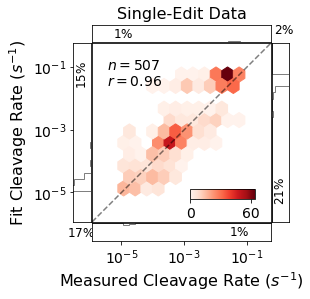

In [827]:
fig, ax = fit_v_meas_plot(res.x, cas9_single_edit_data, pamlen, del_trunc, all_but_insweight, cmap=cas9_cmap)
ax.set_title('Single-Edit Data')
print

All Total variance: 1.6, Residual variance: 0.1, Percent explained: 91.3%
Center Total variance: 0.9, Residual variance: 0.3, Percent explained: 65.2%
Removed 0 / 15,313 / 0 of 15,313 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



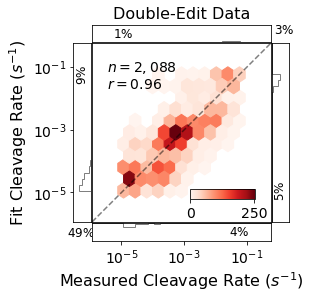

In [828]:
fig, ax = fit_v_meas_plot(res.x, cas9_double_edit_data, pamlen, del_trunc, all_but_insweight, cmap=cas9_cmap)
ax.set_title('Double-Edit Data')
print

All Total variance: 2.1, Residual variance: 0.1, Percent explained: 93.9%
Center Total variance: 1.0, Residual variance: 0.3, Percent explained: 66.1%
Removed 0 / 18,539 / 0 of 18,539 values (100.0%) with (x, 0) / (0, 0) / (0, y). r = nan



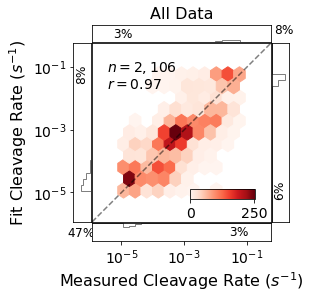

In [829]:
fig, ax = fit_v_meas_plot(res.x, cas9_data, pamlen, del_trunc, all_but_insweight, cmap=cas9_cmap)
fig.savefig('figs/{}_all_but_insweight_model_correlation.eps'.format(real_cas9_var))
fig.savefig('figs/{}_all_but_insweight_model_correlation.png'.format(real_cas9_var), dpi=300)
ax.set_title('All Data')
print

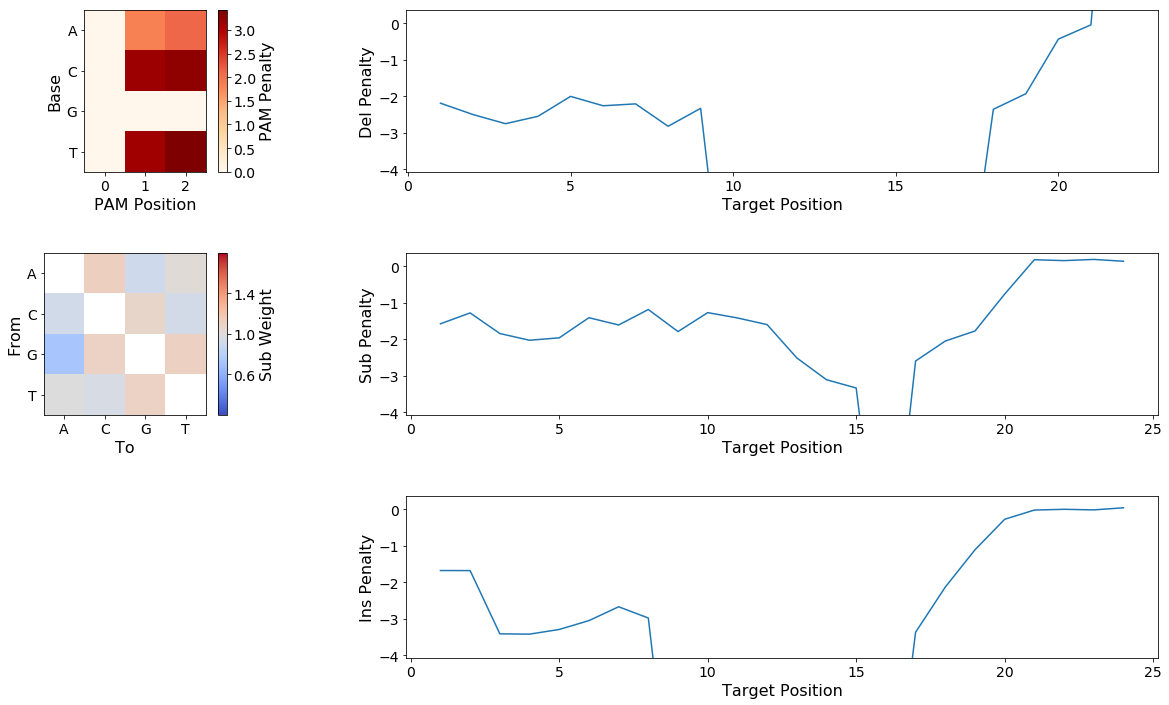

In [188]:
plot_params_all_but_insweight(res.x, pamlen, del_trunc)

# Parameter Comparisons

In [189]:
def correlation_plot(prot):
    if prot == 'Cas12a':
        pamlen = 4
        del_trunc = 1
    else:
        assert prot == 'Cas9', prot
        pamlen = 3
        del_trunc = 2
    
    tlen = 27-pamlen
    pam_spacing = 0.5
    width_ratios = [pamlen*(4+pam_spacing)/3.0, tlen/3.0]
    height_ratios = 3 * np.ones((3,))
    gs = mpl.gridspec.GridSpec(3, 2, width_ratios=width_ratios, height_ratios=height_ratios, 
                               wspace=0.3, hspace=0.5,
                               bottom=0.0, top=1.0, left=0.0, right=1.0)
    fig = plt.figure(figsize=(sum(width_ratios), sum(height_ratios)))
    axes = [plt.subplot(gs[i]) for i in range(6) if i != 4]
    
    def plot_pen(ax_idx, pen, label):
        ax = axes[ax_idx]
        ax.plot(np.arange(1, len(pen) + 1), np.array(pen), label=label)
        ax.set_xlabel('Target Position')
        ax.set_ylim((-1.1*data_span, 0.1*data_span))
        
    def plot_pwm(ax_idx, pwm, label):
        x, y, ticks = [], [], []
        for i in range(pamlen):
            x += list(np.arange(5) + (4+pam_spacing)*i)
            y += list(-pwm[:, i]) + [None]
            ticks += list(np.arange(4) + (4+pam_spacing)*i)
        ax = axes[ax_idx]
        ax.plot(x, y, label=label)
        ax.set_ylim((-0.1, 5))
        ax.set_xticks(ticks)
        if prot == 'Cas12a':
            ax.set_xticklabels(['$%s_{%d}$' % (base, -4 + i) for i in range(pamlen) for base in bases])
        else:
            ax.set_xticklabels(['$%s_{%d}$' % (base, i + 1) for i in range(pamlen) for base in bases])
        ax.set_xlim((-1, 4*pamlen + (pamlen-1)*pam_spacing))
        ax.set_ylabel('PAM Penalty')
        ax.set_xlabel('Base')
        for t in ax.get_xticklabels():
            t.set_fontsize(10)
        
    def plot_trans_mat(ax_idx, subtrans, label):
        subtrans = unwrap_trans_mat(subtrans)
        x, y, ticks = [], [], []
        for i in range(4):
            x += list(np.arange(4) + (3+pam_spacing)*i)
            y += list(subtrans[3*i:3*i+3]) + [None]
            ticks += list(np.arange(3) + (3+pam_spacing)*i)
        ax = axes[ax_idx]
        ax.plot(x, y, label=label)
        ax.set_xticks(ticks)
        ticklabels = []
        for bi in bases:
            for bj in bases:
                if bi == bj:
                    continue
                ticklabels.append('$%s \mapsto %s$' % (bi, bj))
        ax.set_xticklabels(ticklabels, rotation=45)
        ax.set_xlim((-1, 12 + 3*pam_spacing))
        ax.set_ylabel('Transition Weight')
        ax.set_xlabel('Transition')
        for t in ax.get_xticklabels():
            t.set_fontsize(10)
        ylim = ax.get_ylim()
        ax.set_ylim((0, ylim[1]))
        
    def plot_ins_weight(ax_idx, insweight, label):
        axes[ax_idx].plot(insweight, label=label)

    fit_label = 'PAMPWM SubTrans'
    res = fit['{} {}'.format(prot, fit_label)]
    model_func = pampwm_subtrans_model
    pampwm, subtrans = parse_params(res.x, pamlen, del_trunc, model_func)
    plot_pwm(0, pampwm, fit_label)
    
    fit_label = 'PAMPWM SubPen'
    res = fit['{} {}'.format(prot, fit_label)]
    model_func = pampwm_subpen_model
    pampwm, subpen = parse_params(res.x, pamlen, del_trunc, model_func)
    plot_pen(3, subpen, fit_label)
    plot_pwm(0, pampwm, fit_label)

    fit_label = 'PAMPWM SubPen SubTrans'
    res = fit['{} {}'.format(prot, fit_label)]
    model_func = pampwm_subpen_subtrans_model
    pampwm, subpen, subtrans = parse_params(res.x, pamlen, del_trunc, model_func)
    plot_pen(3, subpen, fit_label)
    plot_pwm(0, pampwm, fit_label)
    plot_trans_mat(2, subtrans, fit_label)

    fit_label = 'All but InsWeight'
    res = fit['{} {}'.format(prot, fit_label)]
    model_func = all_but_insweight
    pampwm, subpen, subtrans, delpen, inspen = parse_params(res.x, pamlen, del_trunc, model_func)
    plot_pen(1, delpen, fit_label)
    plot_pen(3, subpen, fit_label)
    plot_pen(4, inspen, fit_label)
    plot_pwm(0, pampwm, fit_label)
    plot_trans_mat(2, subtrans, fit_label)
    
    fit_label = 'Single Effects'
    res = fit['{} {}'.format(prot, fit_label)]
    model_func = single_effects
    pampwm, subpen, subtrans, delpen, inspen, insweight = parse_params(res.x, pamlen, del_trunc, model_func)
    fit_label = 'All'
    plot_pen(1, delpen, fit_label)
    plot_pen(3, subpen, fit_label)
    plot_pen(4, inspen, fit_label)
    plot_pwm(0, pampwm, fit_label)
    plot_trans_mat(2, subtrans, fit_label)
    #plot_ins_weight(4, insweight, fit_label)
    
    axes[1].set_ylabel('Del Penalty')
    axes[3].set_ylabel('Sub Penalty')
    axes[4].set_ylabel('Ins Penalty')

    for ax_idx in [1, 2, 3, 4]:
        axes[ax_idx].legend(fontsize=8)
    axes[0].legend(loc='upper left', fontsize=8)
#    for ax_idx in [0, 1, 3, 4]:
#        axes[ax_idx].legend(loc='upper right', fontsize=8)
#    axes[2].legend(loc='lower right', fontsize=8)

## Cas12a

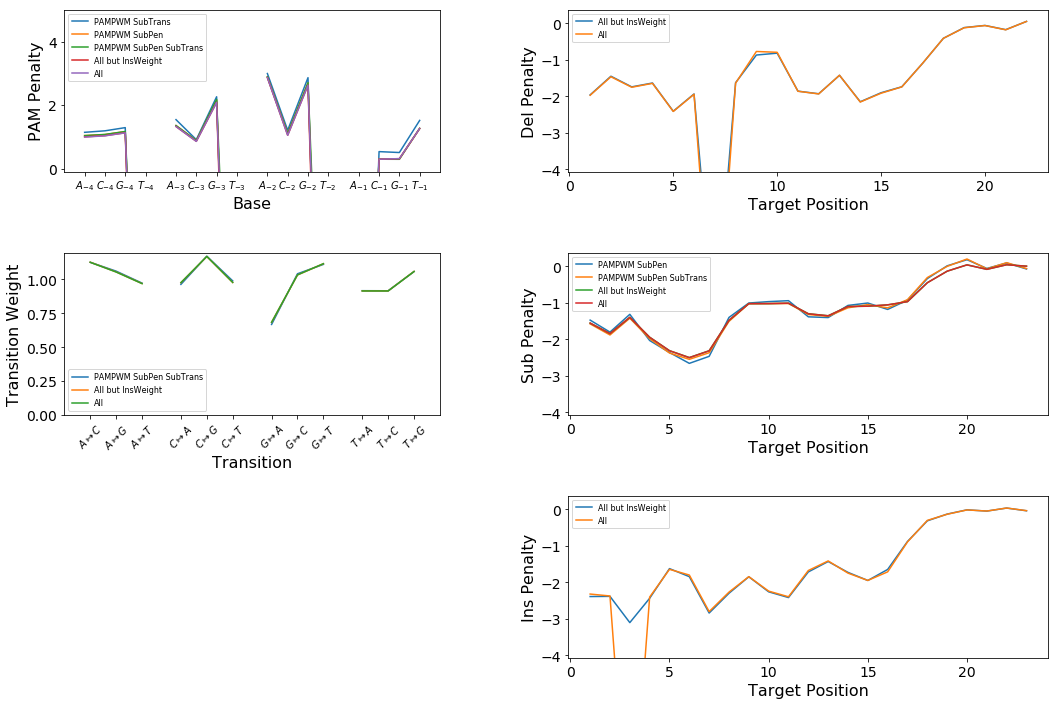

In [190]:
correlation_plot('Cas12a')

## Cas9

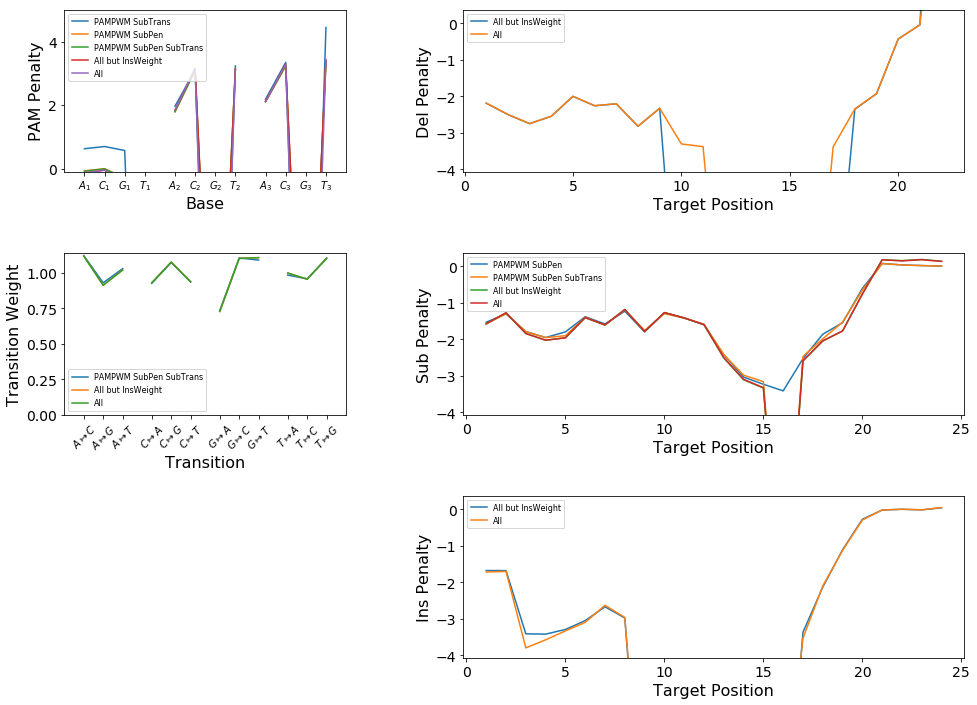

In [191]:
correlation_plot('Cas9')

# Cas12a vs Cas9

In [192]:
import flabpal

In [193]:
def prot_pen_comparison_plot():    
    pamlen = 4
    tlen = 27-pamlen
    pam_spacing = 0.5
    width_ratios = [tlen/3.0]
    height_ratios = 2 * np.ones((3,))
    gs = mpl.gridspec.GridSpec(3, 1, width_ratios=width_ratios, height_ratios=height_ratios, 
                               wspace=0.3, hspace=0.01) #,
                              # bottom=0.2, top=0.9, left=0.2, right=0.9)
    fig = plt.figure(figsize=(sum(width_ratios)*1.3, sum(height_ratios)*1.3))
    axes = [plt.subplot(gs[i]) for i in range(3)]
    
    def plot_pen(ax_idx, pen, label, color):
        ax = axes[ax_idx]
        ax.plot(np.arange(1, 21), np.array(pen[:20]), label=label, color=color, linewidth=2)
        ax.set_ylim((-1.1*data_span, 0.1*data_span))
        ax.set_xlim((0, 21))
        
    prot = 'Cas12a'
    color = flabpal.blue
    fit_label = '{} Single Effects'.format(prot)
    res = fit[fit_label]
    model_func = single_effects
    pampwm, subpen, subtrans, delpen, inspen, insweight = parse_params(res.x, pamlen=4, del_trunc=1, model_func=model_func)
    fit_label = prot
    plot_pen(0, delpen, fit_label, color=color)
    plot_pen(1, subpen, fit_label, color=color)
    plot_pen(2, inspen, fit_label, color=color)
    
    prot = 'Cas9'
    color = flabpal.red
    fit_label = '{} Single Effects'.format(prot)
    res = fit[fit_label]
    model_func = single_effects
    pampwm, subpen, subtrans, delpen, inspen, insweight = parse_params(res.x, pamlen=3, del_trunc=2, model_func=model_func)
    fit_label = 'HF1'# + prot
    plot_pen(0, delpen, fit_label, color=color)
    plot_pen(1, subpen, fit_label, color=color)
    plot_pen(2, inspen, fit_label, color=color)
    
    fs = 18
    axes[0].set_ylabel('Del Penalty', fontsize=fs)
    axes[1].set_ylabel('Sub Penalty', fontsize=fs)
    axes[2].set_ylabel('Ins Penalty', fontsize=fs)
    axes[0].set_xticklabels([])
    axes[1].set_xticklabels([])
    axes[2].set_xlabel('Target Position', fontsize=fs)
    axes[2].set_xticks(range(0, 21, 5))

    for ax in axes:
        ax.legend(loc='lower right', fontsize=11)
        #ax.set_yticks([0, 0.5, 1])
        
    fig.savefig('cas12a_cas9_comparison.eps')
    fig.savefig('cas12a_cas9_comparison.png', dpi=300)

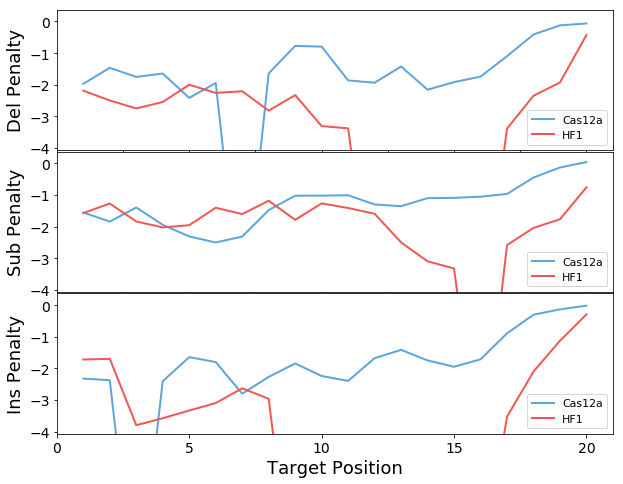

In [194]:
prot_pen_comparison_plot()

# AIC

In [406]:
def gaussian_lnL(y, yhat, sigma):
    return -np.log(np.sqrt(2*np.pi)*sigma) - 0.5*((y-yhat)/sigma)**2

def sigma_lnL_and_AIC(params, loc_data, pamlen, del_trunc, model_func, x0=1.0):
    all_meas, all_fit = get_all_meas_and_fit(params, loc_data, pamlen, del_trunc, model_func)
    def neg_lnL(sigma):
        return -sum(gaussian_lnL(y, yhat, sigma) for y, yhat in zip(all_meas, all_fit))
    res = minimize(neg_lnL, x0=[x0], bounds=[(0.01, 5)], options=dict(maxiter=1e6))
#    assert res.success == True, res
    print res.success
    sigma = res.x[0]
    lnL = -neg_lnL(sigma)
    AIC = 2 * (len(params) + 1) - 2 * lnL  # +1 because sigma is added param
    return sigma, lnL, AIC

In [407]:
AIC_given_label = {}
sigma_given_label = {}
for prot in ['Cas12a', 'Cas9']:
    if prot == 'Cas12a':
        pamlen = 4
        del_trunc = 1
        loc_datas = [
            cas12a_force_sub_data,
            cas12a_force_sub_data,
            cas12a_force_sub_data,
            cas12a_data,
            cas12a_data,
        ]
    else:
        assert prot == 'Cas9', prot
        pamlen = 3
        del_trunc = 2
        loc_datas = [
            cas9_force_sub_data,
            cas9_force_sub_data,
            cas9_force_sub_data,
            cas9_data,
            cas9_data,
        ]
    
    fit_labels = [
        'PAMPWM SubTrans', 
        'PAMPWM SubPen', 
        'PAMPWM SubPen SubTrans', 
        'All but InsWeight', 
        'Single Effects'
    ]
    
    model_funcs = [
        pampwm_subtrans_model,
        pampwm_subpen_model,
        pampwm_subpen_subtrans_model,
        all_but_insweight,
        single_effects
    ]
    
    sigmas, AICs = [], []
    for loc_data, fit_label, model_func in zip(loc_datas, fit_labels, model_funcs):
        if 'InsWeight' in fit_label:
            x0 = 0.5
        else:
            x0 = 1.0
        label = '{} {}'.format(prot, fit_label)
        print label, 
        res = fit[label]
        sigma, lnL, AIC = sigma_lnL_and_AIC(res.x, loc_data, pamlen, del_trunc, model_func, x0=x0)
        AIC_given_label[label] = AIC
        sigma_given_label[label] = sigma

Cas12a PAMPWM SubTrans True
Cas12a PAMPWM SubPen True
Cas12a PAMPWM SubPen SubTrans True
Cas12a All but InsWeight True
Cas12a Single Effects True
Cas9 PAMPWM SubTrans True
Cas9 PAMPWM SubPen True
Cas9 PAMPWM SubPen SubTrans True
Cas9 All but InsWeight True
Cas9 Single Effects True


In [673]:
def AIC_sigma_plots(prot):
    if prot == 'Cas12a':
        pamlen = 4
        del_trunc = 1
        loc_datas = [
            cas12a_force_sub_data,
            cas12a_force_sub_data,
            cas12a_force_sub_data,
            cas12a_data,
            cas12a_data,
        ]
    else:
        assert prot == 'Cas9', prot
        pamlen = 3
        del_trunc = 2
        loc_datas = [
            cas9_force_sub_data,
            cas9_force_sub_data,
            cas9_force_sub_data,
            cas9_data,
            cas9_data,
        ]
    
    fit_labels = [
        'PAMPWM SubTrans', 
        'PAMPWM SubPen', 
        'PAMPWM SubPen SubTrans', 
        'All but InsWeight', 
        'Single Effects'
    ]
    
    model_funcs = [
        pampwm_subtrans_model,
        pampwm_subpen_model,
        pampwm_subpen_subtrans_model,
        all_but_insweight,
        single_effects
    ]
    
    sigmas, AICs = [], []
    for loc_data, fit_label, model_func in zip(loc_datas, fit_labels, model_funcs):
        label = '{} {}'.format(prot, fit_label)
        sigmas.append(sigma_given_label[label])
        AICs.append(AIC_given_label[label])
        
    nfits = len(fit_labels)
    for vals, label in [(sigmas, 'Sigma'), (AICs, 'AIC')]:
        fig, ax = plt.subplots(figsize=(1.5, 2))
        ax.plot(range(nfits), vals, 'o')
        ylim = list(ax.get_ylim())
        ydiff = ylim[1] - ylim[0]
        ylim[0] -= 0.2 * ydiff
        ylim[1] += 0.2 * ydiff
        text_off = 0.1 * ydiff
#        for xx, yy in zip(vals, range(nfits)):
#            ax.text(xx + text_off, yy, '{:.1f}'.format(xx), ha='left')
        ax.set_ylabel(label)
        ax.set_xticks(range(nfits))
        ax.set_xticklabels([
            'Mismatch Bases Only',
            'Mismatch Position Only',
            'Mismatch Position and Bases',
            'Add Indel Positions',
            'Add Insertion Bases',
        ], rotation=90)
        ax.set_title(prot)
        #xlim = ax.get_xlim()
        ax.set_ylim((0, ylim[1]))
        ax.set_xlim((-0.5, 4.5))
        #ax.set_ylim(ylim[::-1])
        
    return fig, ax

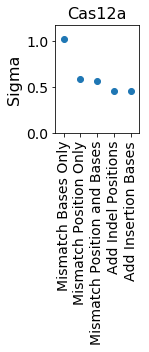

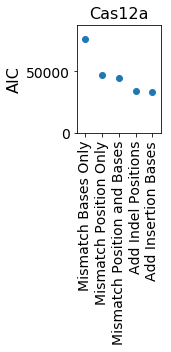

In [674]:
fig, ax = AIC_sigma_plots('Cas12a')
fig.savefig('figs/cas12a_AIC.eps')
fig.savefig('figs/cas12a_AIC.png', dpi=300)

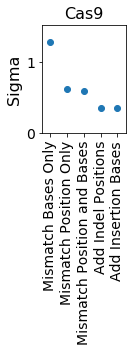

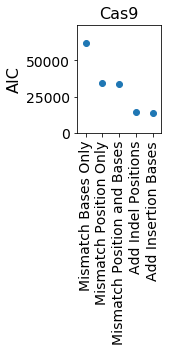

In [675]:
fig, ax = AIC_sigma_plots('Cas9')
fig.savefig('figs/cas9_AIC.eps')
fig.savefig('figs/cas9_AIC.png', dpi=300)

# Output

In [199]:
if not os.path.exists('params'):
    os.mkdir('params')

In [206]:
for prot, real_prot, pamlen, del_trunc in [('Cas12a', 'Cas12a', 4, 1), ('Cas9', real_cas9_var, 3, 2)]:
    for fit_label, model_func in zip([
        'PAMPWM SubTrans', 
        'PAMPWM SubPen', 
        'PAMPWM SubPen SubTrans', 
        'All but InsWeight', 
        'Single Effects'
    ], [
        pampwm_subtrans_model,
        pampwm_subpen_model,
        pampwm_subpen_subtrans_model,
        all_but_insweight,
        single_effects
    ]):
        res = fit['{} {}'.format(prot, fit_label)]
        parsed_params = parse_params(res.x, pamlen, del_trunc, model_func)
        
        out_fname = '{}_{}_params.txt'.format(real_prot.lower(), fit_label.lower().replace(' ', '_'))
        out_fpath = os.path.join('params', out_fname)
        with open(out_fpath, 'w') as out:
            for subparams in parsed_params:
                s = repr(subparams)
                if 'array' in s:
                    s = s.replace('array(', '').replace(')', '').replace('\n', '')
                out.write(s + '\n')